#Gait analysis using 2D computer vision: Identifying abnormal walking pattern by observational gait analysis 

**Background**:

Gait analysis refers to the study of the walking posture of patients. Gait analysis could be used by physiotherapist to diagnose pathological motion, plan treatment and monitor physiotherapy outcomes. 

Clinical gait analysis requires clinical set-up including motion capture markers, ground reaction force measuring mats. Alternatively, the gait of patients could be analyzed by experienced therapists.

During pandemic, tele-rehabilitation is getting popular. If the gait of patients could be captured by pose estimation using deep learning, and extract some of the “gait parameters” or even the “gait health index”, the patients may have some ideas on the progress of recovery. Furthermore, the nursing home can use this technology to help the elderies to monitor their health without high cost. 

This project is based on the idea research of Kidziński, and further explore the potential of using LSTM and CNN-LSTM to improve model performance. And also using the model to test on new data.



**Objective**

With the use of neural network, predict the "healthiness" of patients' gaits with given gait videos. First use OpenPose to obtain time series of joint position in videos. Then train a deep learning model with the dataset that labelled the gait video with clinical assessment result, GDI.

**Reference**:

[1] Ł. Kidziński, B. Yang, J. L. Hicks, A. Rajagopal, S. L. Delp, and M. H. Schwartz, “Deep neural networks enable quantitative movement analysis using single-camera videos,” Nat Commun, vol. 11, no. 1, p. 4054, Dec. 2020, doi: 10.1038/s41467-020-17807-z.

In our project, we will be using the same dataset, but we will try exploring other deep learning methods and compare the results. Also, we will try to use the model on a small new dataset

**Dataset**:

Available:https://simtk.org/projects/video-gaitlab. The dataset was released in the research mentioned before

The dataset includes the position of joints in gait analysis. The position are obtained by pose estimation software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose). The videos were taken while performing clinical gait analysis.

# Project Overview:

Lets try to understand our overall workflow for this project and then dive into each step in greater detail. 

In our proposed workflow, data are collected using a single commodity camera. We use the OpenPose algorithm to extract trajectories of keypoints. Next, these signals are fed into a neural network that extracts the gait deviation index or GDI of the patient in the video.

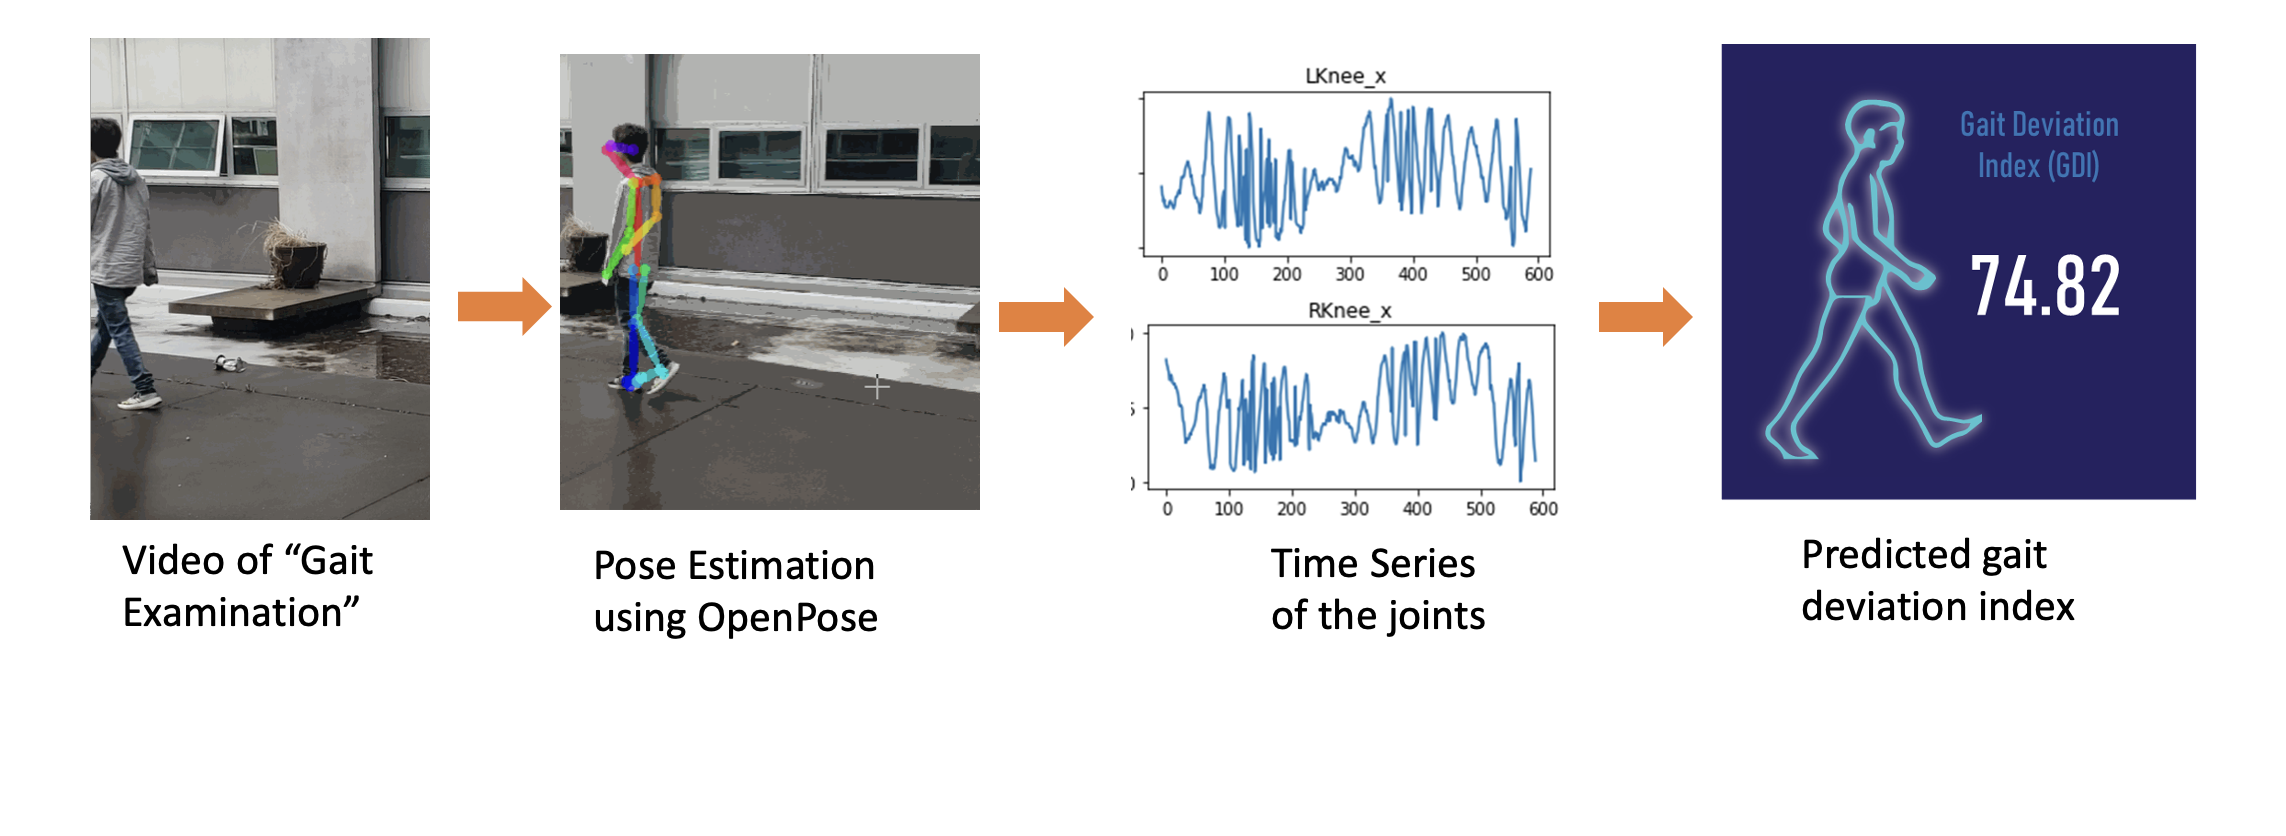

Please follow along for more details on each of these steps.

In [ ]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from  torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim


from zipfile import ZipFile
import shutil
import os
import time
import json

from scipy import interpolate
from scipy import signal

In [ ]:
#Unzip the files in the folder of annotations

start = time.time()
!unzip -q video-gait-v1.zip
end = time.time()
print(end - start)

219.6223292350769


# Data Exploratory Analysis

We need to explore the data and files included in the dataset. The dataset mainly include two components:

1. Keypoint position of gait analysis videos: In the original research, videos of gait analysis in hospital are collected. Then using the OpenPose software (pose estimation), keypoints (e.g. knees, ankles, hips) are recorded are stored in JSON files. Due to privacy issues, the original videos are not included in the dataset.

2. Label: The result of gait analysis are included in the dataset. "Gait Analysis Index" (GDI) is the score of gait analysis result, summarizing how "healthy" is the gait of the patients. 

In [ ]:
# Read the csv files in dataset
gdi = pd.read_csv("annotations/gdi.csv")
alldata= pd.read_csv("annotations/alldata.csv")
surginfo = pd.read_csv("annotations/surgInfo.csv")
video_list = pd.read_csv("annotations/video_list.csv")

In [ ]:
vids=os.listdir('openpose/')
vids=[x.split('-')[0] for x in vids]

print('Number of videos:', len(vids))
vids[:5] #Show examples of the videos

Number of videos: 5722


['13439003', '13263301', '12977509', '16748302', '14399808']

Use a dataframe to summarize the essential information 

In [ ]:
# Extract the exams that contain video files
subset= video_list[video_list['Video_File'].isin(vids)]

# Extract the exams that contain GDI
subset=subset[subset['Exam_ID'].isin(gdi['examid'])]

#Rename the column "Exam_ID" as "examid"
subset.rename(columns={'Exam_ID':'examid'},inplace=True)

#Obtain the left-side GDI
gdi_L = gdi[gdi['side']=='L']
gdi_L=gdi_L.drop(columns='side')
gdi_L.rename(columns={'GDI':'GDI_L'},inplace=True)

#Obtain the right-side GDI
gdi_R = gdi[gdi['side']=='R']
gdi_R=gdi_R.drop(columns='side')
gdi_R.rename(columns={'GDI':'GDI_R'},inplace=True)

#Adding the GDI scores to the subset
subset=pd.merge(subset,gdi_L,on='examid',validate='one_to_one')
subset=subset.drop(columns='Patient_ID')
subset=pd.merge(subset,gdi_R,on='examid',validate='one_to_one')

#Add other info into the subset
subset=pd.merge(subset,
         alldata[['examid','gmfcs','dxmod','dxside','age','bmi']].drop_duplicates('examid'),
         on='examid',validate='one_to_one')


#Filter out the data having gmfcs higher than 4
display(subset.gmfcs.value_counts())
subset = subset[~subset['gmfcs'].isin([4,6])]

#Compute the GDI difference for L and R
subset ['GDI_diff'] = subset['GDI_L'] - subset['GDI_R']

subset

0    1646
2     551
1     522
3     427
4      48
6      13
Name: gmfcs, dtype: int64

examid Video_File      GDI_L  Patient_ID      GDI_R  gmfcs  \
0      14990   14706804  91.356415        5231  86.811488      1   
1      14983   41372903  64.711164        8687  56.420449      3   
2      14982   16396605  67.820874        7929  66.795060      3   
3      14976   18370903  77.205635        9177  91.190480      1   
4      14957   16397602  74.280228        9879  76.228047      3   
...      ...        ...        ...         ...        ...    ...   
3202    2489   13249101  55.889062        4203  64.030474      0   
3203    1612   12734502  64.523427        6315  58.703466      0   
3204    2112   13010801  67.757578        4050  67.956132      0   
3205    2391   13181301  74.869484        4142  78.410441      0   
3206    1937   12909402  85.072749        6419  77.729752      0   

             dxmod     dxside        age        bmi   GDI_diff  
0         Diplegia  Bilateral  17.791781  19.380942   4.544926  
1         Diplegia  Bilateral  10.523288  14.567916   8.290716  
2     Quadriplegia  Bilateral  14.857534  18.393260   1.025814  
3       Hemiplegia      Right  10.764384  20.906560 -13.984845  
4         Diplegia  Bilateral  14.347945  32.676208  -1.947819  
...            ...        ...        ...        ...        ...  
3202     Triplegia       Left   5.810959  17.681268  -8.141412  
3203      Diplegia  Bilateral   6.895890  18.883457   5.819961  
3204     Triplegia      Right   6.953425  15.703347  -0.198554  
3205      Diplegia    Unknown   3.353425  16.816816  -3.540957  
3206      Diplegia    Unknown   7.772603  15.070898   7.342996  

[3146 rows x 11 columns]

## Demographics of data
In this session, we will check the distribution of GDI in the data set.
GDI of 100 or above represent healthy gait
For every 10 points decrease, it represent one standard deviation from the mean of healthy controls.
As the dataset was obtained from hospital, majority of data is expected to have low GDI. 
Now use histogram to visualize the distribution of GDI in the dataset

Details for explanation of GDI can be found in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4909653/#:~:text=The%20Gait%20Deviation%20Index%20(GDI,the%20absence%20of%20gait%20pathology).


Besides GDI, there are some extra info. about the patient, for example age, gmi, and which leg is injured. Visualize the distributuin of GDI for each category of those info.
For example, "gmfcs" (Gross-Motor-Function-Classification-System) describes the walking ability of patient. The details can be found:
https://www.researchgate.net/publication/316555351/figure/fig1/AS:565454381830144@1511826238071/Five-Gross-Motor-Function-Classification-System-GMFCS-Expanded-and-Revised-levels-as.png

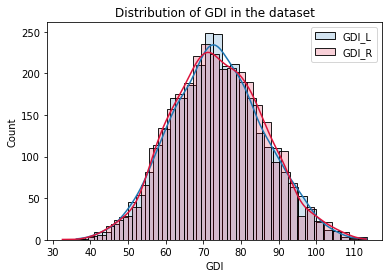

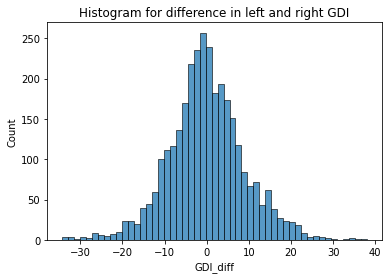

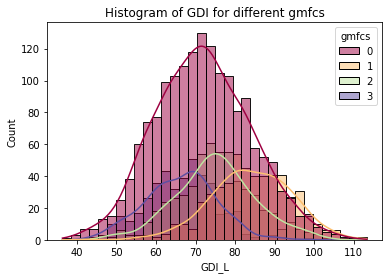

In [ ]:
sns.histplot(data = subset, x='GDI_L', alpha=0.2, label='GDI_L',kde=True)
sns.histplot(data = subset, x='GDI_R',color = 'crimson', 
             alpha=0.2, label = 'GDI_R',kde=True)
plt.xlabel('GDI')
plt.legend()
plt.title('Distribution of GDI in the dataset')
plt.show()

sns.histplot(data=subset, x = 'GDI_diff')
plt.title('Histogram for difference in left and right GDI')
plt.show()

sns.histplot(data=subset,x='GDI_L',hue='gmfcs',palette='Spectral',kde=True)
plt.title('Histogram of GDI for different gmfcs')
plt.show()


In [ ]:
#Dropping the data that have GDI <40
gdi_thres = 40
subset = subset[subset['GDI_L']>=gdi_thres]
subset = subset[subset['GDI_R']>=gdi_thres]

subset.shape

(3141, 11)

In [ ]:
low_gdi = 60 #Threshold for low GDI
high_gdi =90 #Threshold for high GDI

low_gdi_cnt = subset[subset['GDI_L'] <=low_gdi].shape[0]
high_gdi_cnt = subset[subset['GDI_L'] >=high_gdi].shape[0]

print("Number of exam. with GDI <= %i : %i (%0.2f%%)"%(low_gdi,
                                                       low_gdi_cnt,
                                                       low_gdi_cnt/subset.shape[0]*100))

print("Number of exam. with GDI >= %i : %i (%0.2f%%)"%(high_gdi,
                                                       high_gdi_cnt,
                                                       high_gdi_cnt/subset.shape[0]*100))

Number of exam. with GDI <= 60 : 413 (13.15%)
Number of exam. with GDI >= 90 : 312 (9.93%)


Note that most of the data are having GDI in the range 60 to 90. So the regression model is likely to predict GDI in this range in order to achieve low loss (MSE). May need to consider working on data sampling to create a more balanced dataset.

#Splittling Dataset

Split the data into 70% train, 15% validation and 15% test. Each patient can have multiple gait examination in the dataset. For fairness, the patients in test set will not be included in train set.


In [ ]:
#Checking the number of unique value in the subset
print(subset.nunique(),'======\n')

#obtain a list of patientID
patient = subset['Patient_ID'].unique()
np.random.seed(1000)
np.random.shuffle(patient)


#Splitting the data into train,test and validation set.

val_size,test_size = 0.15,0.15 # 15% test; 15% val, 70% train
N = patient.size #Number of patients

split1 = int(N*test_size)
split2= int (N*(test_size+val_size))

patient_test = patient[:split1]
patient_val = patient[split1:split2]
patient_train = patient[split2:]

print('Number of patients for test set: ',patient_test.size)
print('Number of patients for validation set: ',patient_val.size)
print('Number of patients for train set: ',patient_train.size)

examid        3141
Video_File    3141
GDI_L         3141
Patient_ID    1342
GDI_R         3141
gmfcs            4
dxmod           13
dxside           5
age           2389
bmi           2976
GDI_diff      3141
dtype: int64 ======

Number of patients for test set:  201
Number of patients for validation set:  201
Number of patients for train set:  940


In [ ]:
#Splitting the video list according to patient split
train_set=subset[subset['Patient_ID'].isin(patient_train)]
val_set =subset[subset['Patient_ID'].isin(patient_val)]
test_set = subset[subset['Patient_ID'].isin(patient_test)]

#Checking the size of each sets
N = subset.shape[0]
print('Training set size: %i (%0.2f%%)'%(train_set.shape[0],
                                         train_set.shape[0]/N*100))
print('Training set size: %i (%0.2f%%)'%(val_set.shape[0],
                                         val_set.shape[0]/N*100))
print('Training set size: %i (%0.2f%%)'%(test_set.shape[0],
                                         test_set.shape[0]/N*100))

Training set size: 2207 (70.26%)
Training set size: 478 (15.22%)
Training set size: 456 (14.52%)


In [ ]:
#Transfer the videos in training set to a new folder

NewFolder = 'MIE1507_proj_train_set'
df= train_set

if not os.path.exists(NewFolder):
  os.makedirs(NewFolder) #Create a folder

vids = df['Video_File'].values #List of files

for vid in vids:
  path = 'openpose/'+str(vid)+'-processed/'
  try:
    shutil.move(path,NewFolder) #Move the files
  except:
    pass

# Repeat the steps for validation set
NewFolder = 'MIE1507_proj_val_set'
df= val_set

if not os.path.exists(NewFolder):
  os.makedirs(NewFolder) #Create a folder

vids = df['Video_File'].values #List of files

for vid in vids:
  path = 'openpose/'+str(vid)+'-processed/'
  try:
    shutil.move(path,NewFolder) #Move the files
  except:
    pass

# Repeat the steps for test set
NewFolder = 'MIE1507_proj_test_set'
df= test_set

if not os.path.exists(NewFolder):
  os.makedirs(NewFolder) #Create a folder

vids = df['Video_File'].values #List of files

for vid in vids:
  path = 'openpose/'+str(vid)+'-processed/'
  try:
    shutil.move(path,NewFolder) #Move the files
  except:
    pass

#Data Preprocessing

The training dataset includes json files obtained by OpenPose pose estimation. The json files include the location of joints (e.g. shoulder, knees, etc.) detected at each time frames of the video. We wish to obtain time series of each of the joint position to be the features for training the network. Also, we will obtain some features that are commonly required for gait analysis, such as knee angles.
This session aims at obtaining the features required, and performing preprocessing such as normalization.

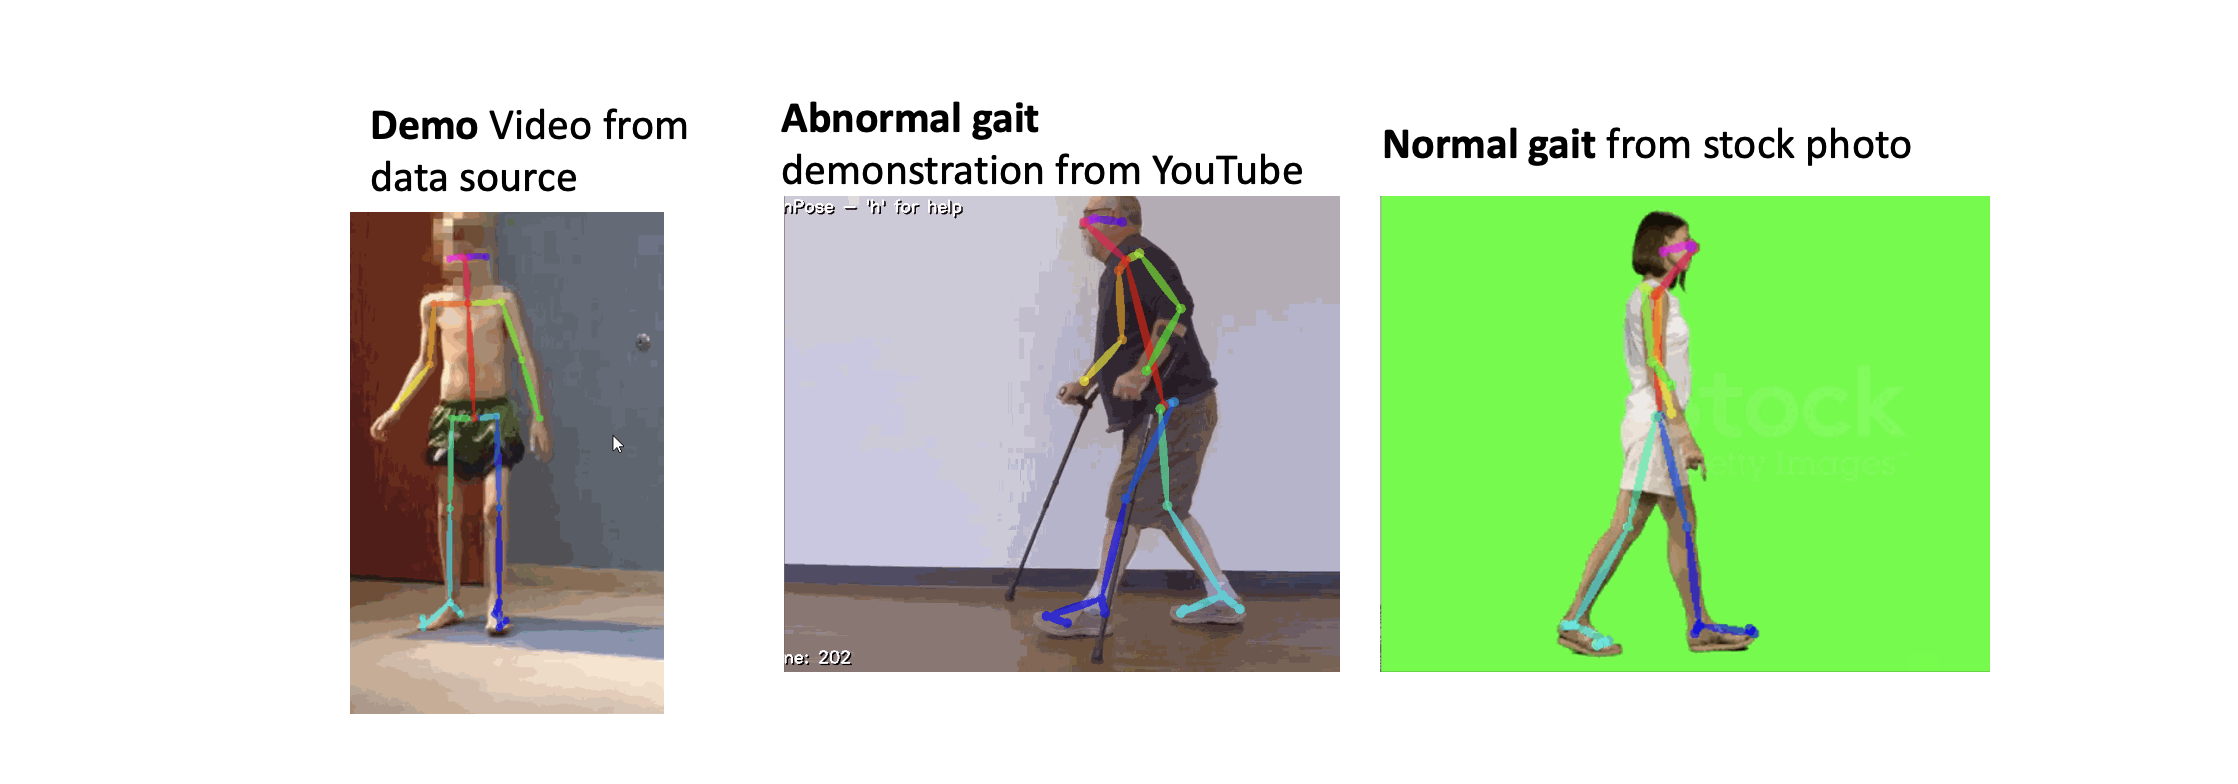

In [ ]:
def get_json_name(vid_name, directory):
  ''' Get a list of paths for json files of a specific video
  Args: 
    vid_name: the name of the video, e.g. 14760804-processed
    directory: the path of the folder that contains the json files

  Returns:
    json_list: a list of paths 
  '''

  json_list = []

  N= len(os.listdir(directory)) #Number of frames

  for i in range(N):

    file_name = '%s_%s_keypoints.json' %(vid_name,str(i).zfill(12))
    path = directory + file_name
    
    json_list.append(path)

  return json_list

vid_id= 12918307
vid_name = str(vid_id)+'-processed'
directory = 'MIE1507_proj_train_set/'+vid_name+'/'

json_list = get_json_name(vid_name,directory)
json_list[200]

'MIE1507_proj_train_set/12918307-processed/12918307-processed_000000000200_keypoints.json'

In [ ]:
# Checking the format of the json files
trial = json_list[200] #Select json file at a particular frame

with open(trial) as data_file:
  data=json.load(data_file)

print(data.keys())
print(len(data['people'])) #Check the number of persons detected
print(len(data['people'][0]['pose_keypoints_2d'])) #Check number of keypoints

dict_keys(['version', 'people'])
2
75


positions of 25 keypoints (e.g. nose, left knee, etc.) are included in the json files. For each of the keypoints, there are x-position, y-position and detection confidence

Explaination of the keypoints from openpose could be found in the link below:
https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_02_output.html

In [ ]:
#Create a mapping for the keypoint position and the index in json.

joint_label = ['Nose', 'Neck','RShoulder','RElbow','RWrist','LShoulder',
                  'LElbow','LWrist','MidHip','RHip','RKnee','RAnkle',
                  'LHip','LKnee','LAnkle','REye','LEye','REar','LEar',
                  'LBigToe','LSmallToe','LHeel','RBigToe','RSmallToe',
                  'RHeel']

point_lbl = {}

for i,label in enumerate(joint_label):
  point_lbl[label+'_x']=i*2
  point_lbl[label+'_y']=i*2+1

len(list(point_lbl.keys()))

50

(50, 589)


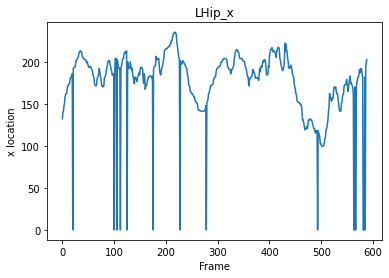

In [ ]:
def convert_json2np(vid_name,directory,crop=True):
  """Extract the pose keypoints of the patient from the openpose json files
  
  Args:
    vid_name: the name of the video, e.g. 14706804-processed
    directory: the folder path of the json file, e.g. openpose/14706804-processed/

  """
  
  json_file = get_json_name(vid_name,directory)

  #Initialize the result
  resL = np.zeros((len(json_file),75))
  resL[:] = np.nan

  for frame,path in enumerate(json_file):
    
    with open(path) as data_file:
      data=json.load(data_file)

    for person in data['people']:

      keypoints = person['pose_keypoints_2d']
      xcoords = [keypoints[i] for i in range(len(keypoints)) if i % 3 == 0]
      counter = 0 #Count number of person

      # Some of the videos include the clinician, 
      # which cause the openpose json file having more than one person.
      # As suggested by the original paper,
      # clinician do not appear on the left in video frames during the exam.
      # Thus using np.max(xcords)<320 to identify the subject (patient) in vid. 
      if crop == True:
        if np.max(xcoords) < 320:
            if(counter > 0):
                print("duplicate person on left half of video %s") % vid_name
                print(vid_name)
            counter += 1
            resL[frame-1,:] = keypoints
      else:
        resL[frame-1,:] = keypoints
      

  #If there are no person detected, the value will be nan.
  #Drop the frames which do not include any person.
  check = np.apply_along_axis(lambda x: np.any(~np.isnan(x)),1,resL)
  resL = resL[check]
  
  # Transpose the numpy
  resL = resL.transpose()
  
  # Includes only the x,y position of keypoints
  row = [i for i in  range(75) if (i+1)% 3 != 0]
  resL= resL[row]

  return resL


# Trial for the function
vid_id= 12918307
vid_name = str(vid_id)+'-processed'
directory = 'MIE1507_proj_train_set/'+vid_name+'/'

trial=convert_json2np(vid_name,directory)
print(trial.shape)

plt.plot(trial[point_lbl['LHip_x']])
plt.title('LHip_x')
plt.xlabel('Frame')
plt.ylabel('x location')
plt.show()

From the plot, there are some missing detection of points. At some particular frames, the openPose could not detect the keypoints, maybe due to blocked by body/objects. We apply interpolation for those missing values to reduce the noise of our time series.

But before applying interpolation to fill the missing values, we need to check the missing rate. If the data contains too many missing values (e.g. 50%), we should drop the data instead of relying on interpolation.

In [ ]:
#Compute the percentage of missing values on specific keypoints

N = trial[point_lbl['LHip_x']].size #Length of time series
missing_cnt = (trial[point_lbl['LHip_x']]<=0).sum()
missing_rate = missing_cnt /N 
print('Missing rate for L_Hip: %0.2f%%'%(missing_rate*100))

#Compute the avg. missing rate for critical keypoints (legs related)
critical_keypnts = ['LHip','RHip','MidHip','LKnee','RKnee', 'LAnkle','RAnkle',
                    'LBigToe', 'RBigToe', 'LSmallToe','RSmallToe',
                    'LHeel','RHeel']
critical_keypnts_x = [i+'_x' for i in critical_keypnts]
critical_keypnts_y=[i+'_y' for i in critical_keypnts]
critical_keypnts =critical_keypnts_x+critical_keypnts_y

col = [point_lbl[i] for i in critical_keypnts]
N= trial[col].size
missing_cnt = (trial[col]<=0).sum()
missing_rate = missing_cnt /N 
print('Missing rate for critical keypoints: %0.2f%%'%(missing_rate*100))

Missing rate for L_Hip: 2.89%
Missing rate for critical keypoints: 4.39%


In [ ]:
#Create a dictionary to include all time-series data in dataset

ts = {} #Time-Series
error_list =[] #List of videos that faced errors when creating time-series numpy


start = time.time() #Time

#Convert train_set into timeseries
dataset = train_set
directory = 'MIE1507_proj_train_set/'

for idx  in dataset.index:

  vid_id = dataset['Video_File'][idx]
  vid_name = str(vid_id)+'-processed'
  path = directory + vid_name+'/'

  try: 
    time_series = convert_json2np(vid_name,path)
    ts[dataset['examid'][idx]] = time_series
  except:
    error_list.append(dataset['examid'])
    print('exam %s cannot be converrted'%vid_id)

#Convert val_set into timeseries

dataset = val_set
directory = 'MIE1507_proj_val_set/'

for idx  in dataset.index:

  vid_id = dataset['Video_File'][idx]
  vid_name = str(vid_id)+'-processed'
  path = directory + vid_name+'/'

  try: 
    time_series = convert_json2np(vid_name,path)
    ts[dataset['examid'][idx]] = time_series
  except:
    error_list.append(dataset['examid'])
    print('exam %s cannot be converrted'%vid_id)

#Convert test_Set into timeseries

dataset = test_set
directory = 'MIE1507_proj_test_set/'

for idx  in dataset.index:

  vid_id = dataset['Video_File'][idx]
  vid_name = str(vid_id)+'-processed'
  path = directory + vid_name+'/'

  try: 
    time_series = convert_json2np(vid_name,path)
    ts[dataset['examid'][idx]] = time_series
  except:
    error_list.append(dataset['examid'])
    print('exam %s cannot be converrted'%vid_id)

print('Time:', time.time()-start)

exam 41438704 cannot be converrted
exam 13507507 cannot be converrted
exam 16999204 cannot be converrted
exam 40892005 cannot be converrted
exam 17476201 cannot be converrted
exam 13382701 cannot be converrted
Time: 304.67363691329956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


Text(0.5, 1.0, 'Histogram for % of missing values')

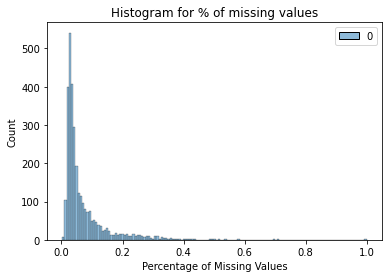

In [ ]:
missing_rates = {} #Percentage of missing values for each data

for key in ts.keys():
  time_series =ts[key] 
  N= time_series[col].size #Length of time-series * Number of columns selected
  missing_cnt = (time_series[col]<=0).sum() #Total number of missing values
  missing_rate = missing_cnt /N #Percentage of missing values
  missing_rates[key] = missing_rate

sns.histplot(missing_rates.values())
plt.xlabel('Percentage of Missing Values')
plt.title('Histogram for % of missing values')

In [ ]:
#If the data contains too many missing values,
# Even interpolation cannot solve the issues, and the data should be droppped

threshold_missing = 0.2 #Threshold on percentage of missing values

#List of exams that have too many missing values in time series
drop_list =[i for i in missing_rates if missing_rates[i] >=threshold_missing ]

#Check how many data we will drop
thre_missing_cnt = len(drop_list)
print('%i data have more than %i%% missing values'%(thre_missing_cnt,
                                                    threshold_missing*100))
print('Corresponding percentage: %0.2f%%'%(thre_missing_cnt/len(missing_rates)*100))

drop_list = drop_list + error_list

221 data have more than 20% missing values
Corresponding percentage: 7.05%


In [ ]:
train_set= train_set[~train_set['examid'].isin(drop_list)]
val_set = val_set[~val_set['examid'].isin(drop_list)]
test_set = test_set[~test_set['examid'].isin(drop_list)]

# Checking the number of remaining data
print('train_set size: ', train_set.shape[0])
print('val_set size: ', val_set.shape[0])
print('test_set size: ', test_set.shape[0])

train_set size:  2049
val_set size:  448
test_set size:  423


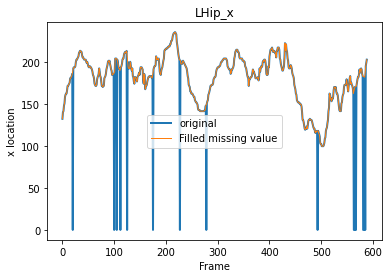

In [ ]:
def fill_missing (x):
  """Fill the missing values by interpolation
  """

  y=x.copy()
  y[y==0]=np.nan #Convert the 0 values into nan
  
  try: 
    missing_value = np.where(np.isnan(y))

    #Create the interpolation function by interpolate.interp1d
    f = interpolate.interp1d(np.argwhere(y>0).squeeze(),
                            y[np.where(y>0)],kind="linear",
                            bounds_error=False)
    
    y=f(np.arange(y.shape[0])) #Apply the interpolation
    y[np.isnan(y)]=y[np.isfinite(y)].mean() #Handle the nan data at the beginning 

    return y
  
  #Some of the keypoints may not be detected, 
  #e.g. eyes not detected due to face are blurred for privacy reasons
  #For this case, return the original time series (zeros) 
  except:
    return x


#Apply the fill_missing function on each of the channels
trial_filled = np.apply_along_axis(fill_missing,
                                   arr=trial,axis=1)

#Visualize the result
plt.plot(trial[point_lbl['LHip_x']],linewidth=2,
         label='original')
plt.plot(trial_filled[point_lbl['LHip_x']],linewidth=1,
         label='Filled missing value')
plt.title('LHip_x')
plt.xlabel('Frame')
plt.ylabel('x location')
plt.legend()
plt.show()

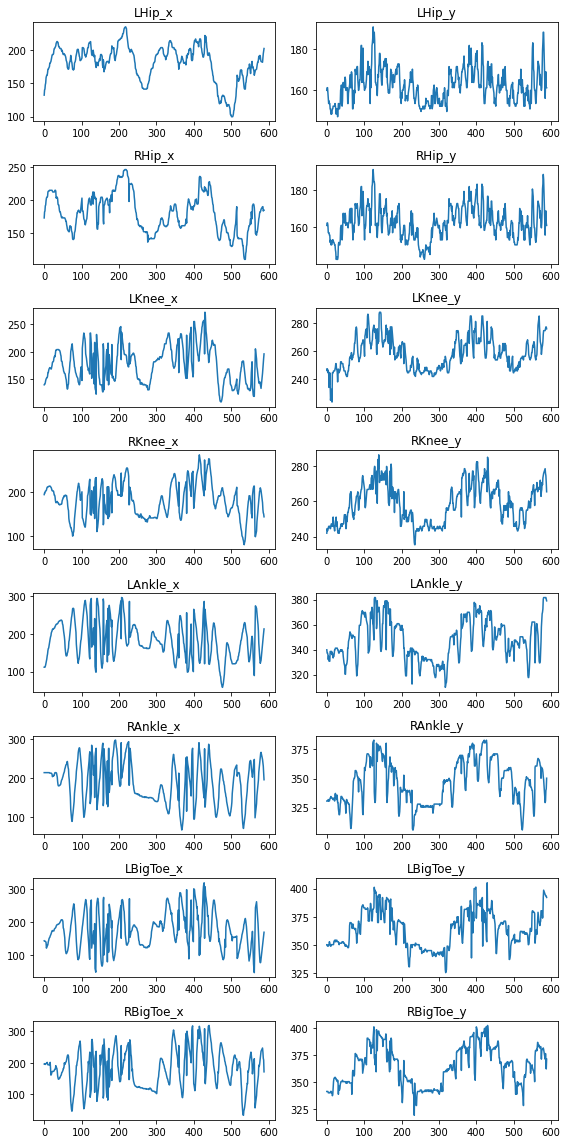

In [ ]:
# Visualizing the time series for some keypoints
def show_plots (input, keypoints=['LHip','RHip','LKnee',
                                  'RKnee','LAnkle','RAnkle',
                                  'LBigToe','RBigToe'], map=point_lbl):
 
  N=len(keypoints) #Nubmer of plots
  k=1

  fig = plt.subplots(N,2,figsize=(8,N*2))

  for point in keypoints:

    plt.subplot(N,2,k)
    plt.plot(input[map[point+'_x']])
    plt.title(point+'_x')
    k+=1

    plt.subplot(N,2,k)
    plt.plot(input[map[point+'_y']])
    plt.title(point+'_y')
    k+=1

  plt.tight_layout()
  plt.show() 

show_plots(trial_filled)

The video input may have different resolution, so the keypoint position may not be in same scale. 

Therefore, we would like to know the relative position of the keypoints with reference to the position of the person, instead of the absolute position in the frame. Using the hip position as the reference of the position of the person, we can obtain the relative position of keypoints.

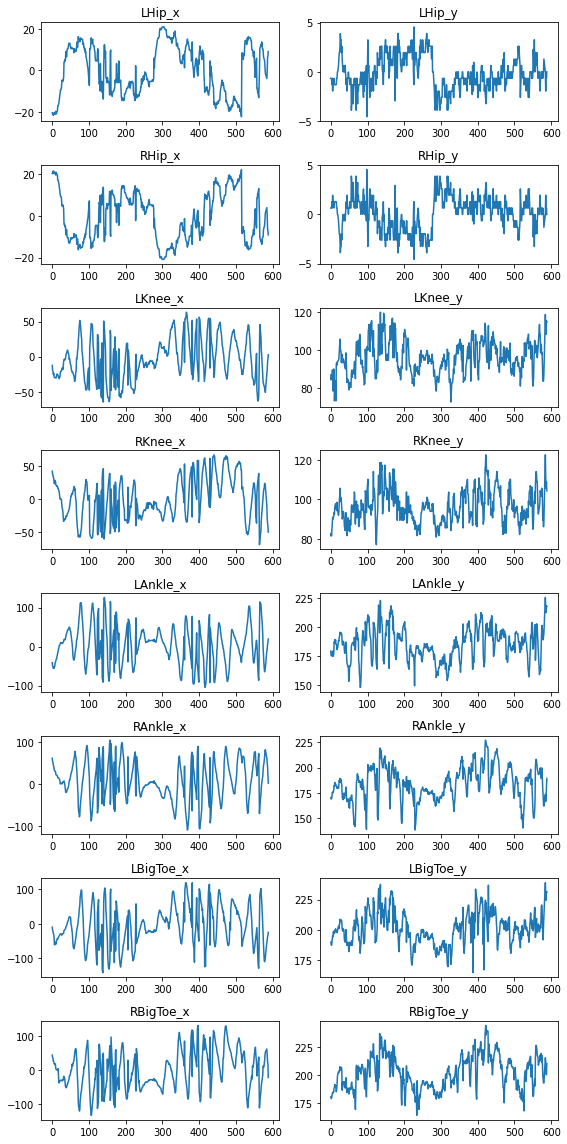

In [ ]:
def get_position (input, keypoint, point_lbl):
  ''' Obtain the time-series for a keypoint
  Args:
    input: the time-series (np array) that included all the keypoints
    keypoint: the keypoint we would like to obtain, e.g. 'LHips'
    point_lbl: the dictionary mapping of index and keypoints
  '''  
  x= input[point_lbl[keypoint+'_x']]
  y= input[point_lbl[keypoint+'_y']]

  position = np.array([x,y]).T

  return position

def get_rel_position (input, ref_point, keypoints, point_lbl):
  ''' Obtain the relative position of a point
  '''

  out = input.copy()

  for point in keypoints:
    abs_pos = get_position(input, point, point_lbl)
    rel_pos = abs_pos - ref_point
    out[point_lbl[point+'_x']]=rel_pos[:,0]
    out[point_lbl[point+'_y']]=rel_pos[:,1]
  
  return out

#Obtain the "reference coordinate" of the person
lhip = get_position(trial_filled,'LHip',point_lbl)
rhip = get_position(trial_filled,'RHip',point_lbl)
ref_point = (lhip+rhip)/2

#Obtain the relative position
trial_rel = get_rel_position(trial_filled,ref_point,
                             joint_label,point_lbl)

show_plots(trial_rel)

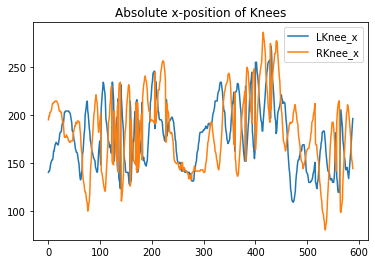

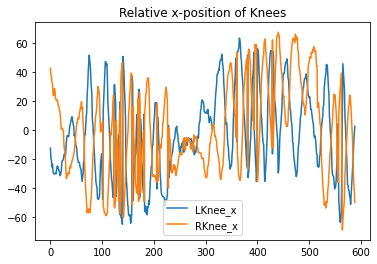

In [ ]:
plt.plot(trial_filled[point_lbl['LKnee_x']],
         label='LKnee_x')
plt.plot(trial_filled[point_lbl['RKnee_x']],
         label='RKnee_x')
plt.legend()
plt.title('Absolute x-position of Knees')
plt.show()

plt.plot(trial_rel[point_lbl['LKnee_x']],
         label='LKnee_x')
plt.plot(trial_rel[point_lbl['RKnee_x']],
         label='RKnee_x')
plt.legend()
plt.title('Relative x-position of Knees')
plt.show()

From the plots, we can see the artifacts of the person changing the direction of walking at ~frame250. We can see that the time-series pattern of walking forward and backward is different. Including a feature to describe the walking direction may help the model generalize.

If the person is facing right, front ankle_x - front toe_x \<\0 ;
and back ankle_x - back toe_x \<\0

If the person is facing left, the result is opposite

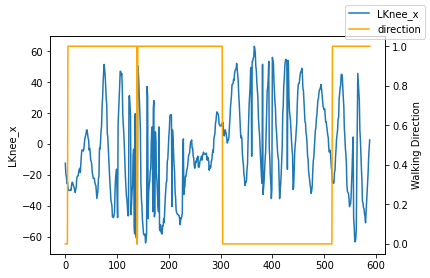

In [ ]:
def get_orientation(x,point_lbl):
  ''' Obtain the walking direction
  Returns:
    out: the walking direction at each time frame,
          0 means walking from right to left; 1 means left to right
  '''
  L = get_position(x, 'LAnkle',point_lbl)-get_position(x, 'LBigToe', point_lbl)
  R= get_position(x, 'RAnkle',point_lbl)-get_position(x,'RBigToe',point_lbl)

  out = L[:,0]+R[:,0]
  out = np.where(out>=0,1,0)
  return out

direction = get_orientation(trial_rel,point_lbl)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(get_position(trial_rel,'LKnee',point_lbl)[:,0],
         label='LKnee_x')
ax2.plot(direction,c='orange',label='direction')
ax1.set_ylabel('LKnee_x')
ax2.set_ylabel('Walking Direction')
fig.legend()
plt.show()

As the perspective in the video may be changing, we scale the position by a reference scale of the person.

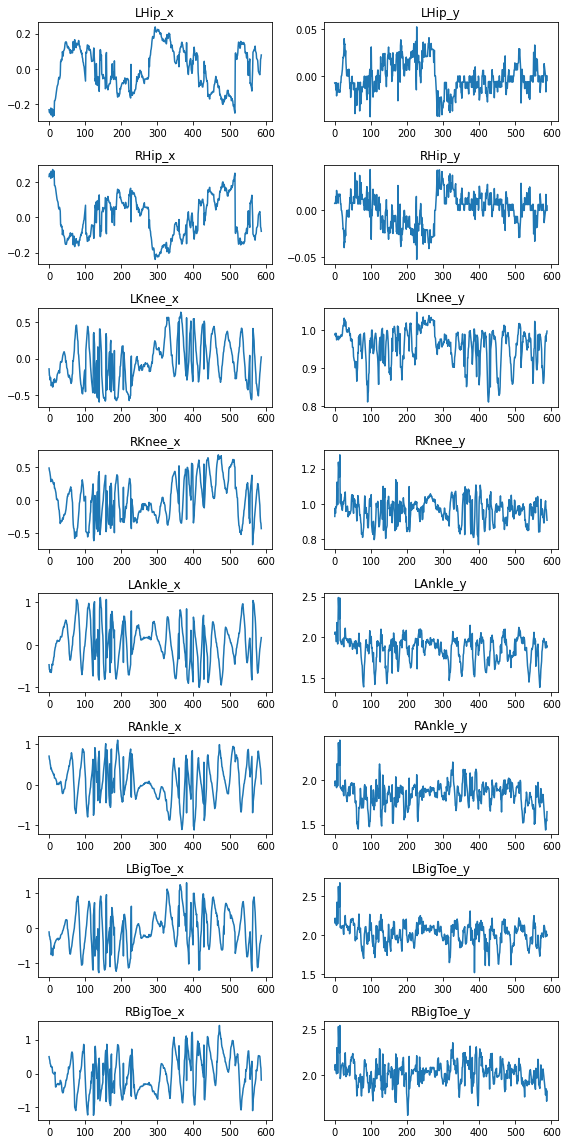

In [ ]:
lhip = get_position (trial_rel,'LHip',point_lbl)
lknee = get_position (trial_rel,'LKnee',point_lbl)
scale_ref = np.linalg.norm(lhip-lknee,axis=1)

trial_scaled = trial_rel / scale_ref
show_plots(trial_scaled)

Then, we obtain the knee angles and ankle angles. In conventional gait analysis, knee angles and ankle angles are important features.

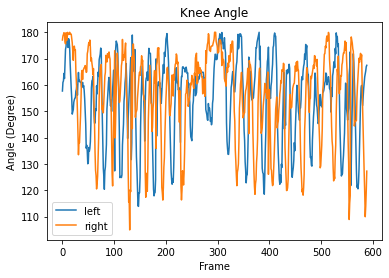

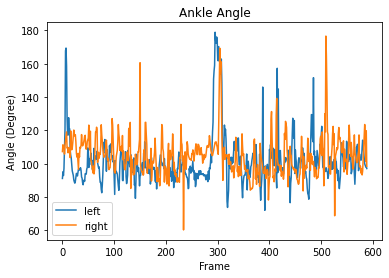

In [ ]:
def get_angle (p_A,p_B,p_C):
  ''' Obtain inner angle of three points by dot products
  '''  
  p_BA=(p_A-p_B)
  p_BC=(p_C-p_B)

  dot_prod = np.sum(p_BA*p_BC,axis=1)
  BA_norm = np.linalg.norm(p_BA,axis=1)
  BC_norm = np.linalg.norm(p_BC,axis=1)

  y=dot_prod/(BA_norm*BC_norm)

  theta = np.arccos(y)
  return np.degrees(theta)


L_knee_angle = get_angle(get_position(trial_scaled,'LHip',point_lbl),
                       get_position(trial_scaled,'LKnee',point_lbl),
                       get_position(trial_scaled,'LAnkle',point_lbl))

R_knee_angle = get_angle(get_position(trial_scaled,'RHip',point_lbl),
                       get_position(trial_scaled,'RKnee',point_lbl),
                       get_position(trial_scaled,'RAnkle',point_lbl))

L_ankle_angle = get_angle(get_position(trial_scaled,'LKnee',point_lbl),
                       get_position(trial_scaled,'LAnkle',point_lbl),
                       get_position(trial_scaled,'LBigToe',point_lbl))
R_ankle_angle = get_angle(get_position(trial_scaled,'RKnee',point_lbl),
                       get_position(trial_scaled,'RAnkle',point_lbl),
                       get_position(trial_scaled,'RBigToe',point_lbl))

plt.plot(L_knee_angle,label='left')
plt.plot(R_knee_angle,label='right')
plt.xlabel('Frame')
plt.ylabel('Angle (Degree)')
plt.legend()
plt.title('Knee Angle')
plt.show()

plt.plot(L_ankle_angle,label='left')
plt.plot(R_ankle_angle,label='right')
plt.xlabel('Frame')
plt.ylabel('Angle (Degree)')
plt.title('Ankle Angle')
plt.legend()
plt.show()

The length of each video may be different, but we have to ensure the shape of input for the neural network to be the same, thus we use "window" to obtain the required data

(14, 50, 120)


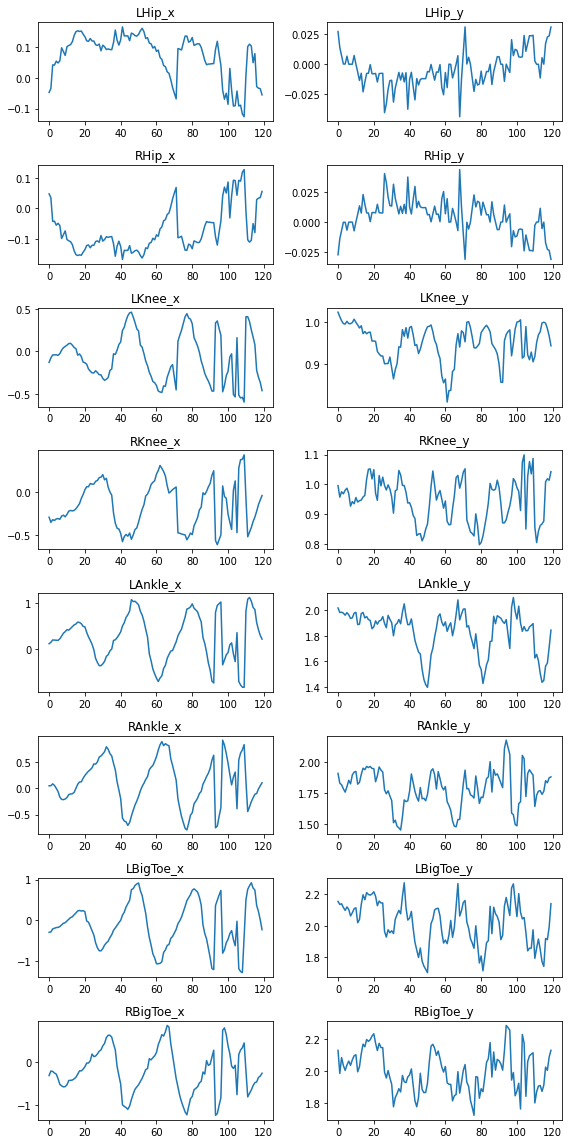

In [ ]:
def get_windows(input, start =30, window_size=120,step=30,end =5*30):

  for i in range (start,input.shape[1]-end,step):
    
    window = input[:,i:i+window_size]
    window = np.expand_dims(window,axis=0)
    
    try:
      windows=np.append(windows,window,axis=0)
    except:
      windows=window
  
  return windows

trial_windows=get_windows(trial_scaled)
print(trial_windows.shape)

show_plots(trial_windows[0])

The time-series data obtained before are in different scale, position of joints are usually in range -10 to 10, while the angle are in range 0 to 180. Having large difference of scales between features may cause difficulties in back-propagation in neural network (e.g. small learning rate works well for small scale features but not the large scale features). So, we normalize the time-series features before training the model

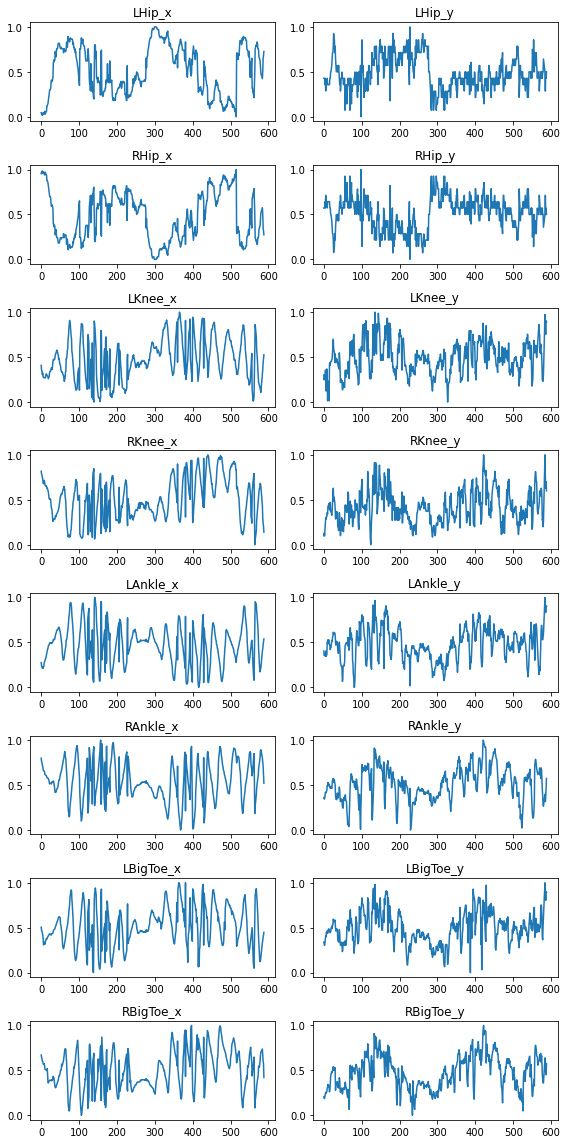

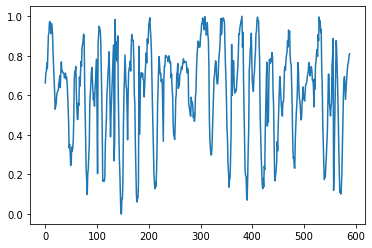

In [ ]:
def normalize_timeSeries (x):
  max = x.max()
  min = x.min()
  return (x-min)/(max-min)

trial_norm = np.apply_along_axis(normalize_timeSeries,
                                 arr=trial_rel,axis=1)
show_plots(trial_norm)
plt.plot(normalize_timeSeries(L_knee_angle))

From observation, some of the keypoints could not be detected in some of the videos. For examples, faces are blurred in some of the videos due to privacy concern, thus eyes, ears and noses could not be detected. As these keypoints are not likely to be critical for gait analysis, we dropped those time series

In [ ]:
# Drop some time series
def drop_keypoints (x, keypoints,idx_map):
  
  new_map = idx_map.copy()
  for i in keypoints:
    new_map.pop(i+'_x')
    new_map.pop(i+'_y')

  #Select keypoints that are not removed
  out_x = x[list(new_map.values())]

  #sort the dict. after removing the keypoints
  new_map = sorted(new_map.items(), key=lambda item: item[1])

  #Assign new index
  out_map = {}
  idx=0
  for k,v in new_map:
    out_map[k] = idx
    idx+=1

  return out_x, out_map

trial_dropped,new_map= drop_keypoints(trial_norm,
                                      ['Nose','REye','LEye','REar','LEar'],point_lbl)
trial_dropped.shape

(40, 589)

Try to create frequency domain features also

(40, 589)


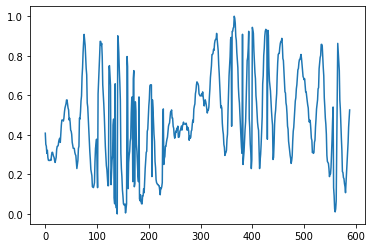

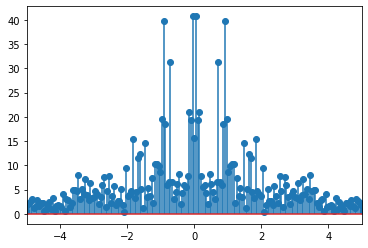

In [ ]:
from scipy import fftpack
trial_f = fftpack.fft(trial_dropped- trial_dropped.mean())
trial_f = abs(trial_f)
print(trial_f.shape)


plt.plot(trial_dropped[new_map['LKnee_x']])
plt.show()
freq = fftpack.fftfreq(trial_dropped[new_map['LKnee_x']].size) * 30
plt.stem(freq, trial_f[new_map['LKnee_x']],use_line_collection=True)
plt.xlim(-5, 5)
plt.show()

Now, put all the pre-processing steps into a single function.

In [ ]:
#Create a function for obtaining the features required
def get_features (video_name, directory, crop=True, window_size=120,step=30,end =5*30,
                  drop_list = ['Nose','REye','LEye','REar','LEar']):
  
  #Obtain the time series from json file
  out = convert_json2np(video_name,directory,crop=crop)
  
  #Fill the missing data
  out = np.apply_along_axis(fill_missing,
                            arr=out,axis=1)

  #Get the relative position of keypoints
  lhip = get_position(out,'LHip',point_lbl)
  rhip = get_position(out,'RHip',point_lbl)
  ref_point = (lhip+rhip)/2

  out = get_rel_position(out,ref_point,
                             joint_label,point_lbl)

  #Scale the position of keypoints
  lhip = get_position (out,'LHip',point_lbl)
  lknee = get_position (out,'LKnee',point_lbl)
  scale_ref = np.linalg.norm(lhip-lknee,axis=1)

  out = out / scale_ref


  #Drop some of the keypoints
  out,new_map = drop_keypoints(out, drop_list,point_lbl)

  #Obtain the direction of walking
  direction = get_orientation(out,new_map)

  #Obtain knee angles and ankle angles
  L_knee_angle = get_angle(get_position(out,'LHip',new_map),
                       get_position(out,'LKnee',new_map),
                       get_position(out,'LAnkle',new_map))

  R_knee_angle = get_angle(get_position(out,'RHip',new_map),
                        get_position(out,'RKnee',new_map),
                        get_position(out,'RAnkle',new_map))

  L_ankle_angle = get_angle(get_position(out,'LKnee',new_map),
                        get_position(out,'LAnkle',new_map),
                        get_position(out,'LBigToe',new_map))
  R_ankle_angle = get_angle(get_position(out,'RKnee',new_map),
                        get_position(out,'RAnkle',new_map),
                        get_position(out,'RBigToe',new_map))
  
  knee_dist = get_position(out,'LKnee',new_map) -\
              get_position(out,'RKnee',new_map)
  knee_dist = np.linalg.norm(knee_dist,axis=1)

  out = np.vstack([out,L_knee_angle,R_knee_angle,
                   L_ankle_angle,R_ankle_angle,knee_dist])
  

  #Obtain windows
  out=get_windows(out,window_size=window_size,
                  step=step, end= end)


  #Detrend
  out = scipy.signal.detrend(out)

  #Normalize each window
  out = np.apply_along_axis(normalize_timeSeries,
                            arr = out, axis=2)



  #Add direction
  out = np.concatenate([out,
                        get_windows(direction.reshape(1,direction.size),
                                    window_size=window_size,
                                    step=step,
                                    end=end)],
                       axis=1)



  #Convert the datatype to torch.Tensor
  out=torch.Tensor(out)

  return out


# Trial for the function
vid_id= 12918307
vid_name = str(vid_id)+'-processed'
directory = 'MIE1507_proj_train_set/'+vid_name+'/'

features = get_features(vid_name,directory)
features.shape

torch.Size([14, 46, 120])

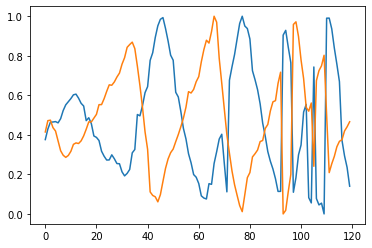

In [ ]:
#Pick some keypoints to visualize for checking
frame = 0
plt.plot(features[frame,24,:])
plt.plot(features[frame,36,:])
plt.show()

Obtain the features for all videos in the training set

In [ ]:
X_train=torch.Tensor()
y_train=torch.Tensor()
id_train = [] 

start = time.time()
for idx in train_set.index:

  vid_id=train_set['Video_File'][idx]
  label = torch.Tensor([train_set['GDI_L'][idx],
                        train_set['GDI_R'][idx]])


  vid_name = str(vid_id)+'-processed'
  directory='MIE1507_proj_train_set/'+vid_name+'/'


  try:
    features = get_features(vid_name,directory)
    n= features.shape[0] #Number of samples created per video
    labels = torch.ones([n,2])*label

    
    X_train=torch.cat((X_train, features),0)
    y_train=torch.cat((y_train,labels),0)
    id_train.extend([train_set['examid'][idx]]*n)

  except: #For debug, list the vids that caused errors
    print('Error occurs for video %s'%vid_id)

print('Computation Time: ', time.time()-start)
print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of id_train: ', len(id_train))

Error occurs for video 41438704
Error occurs for video 13507507
Error occurs for video 16999204
Error occurs for video 14631901
Computation Time:  432.2538480758667
Shape of X_train:  torch.Size([26230, 46, 120])
Shape of y_train:  torch.Size([26230, 2])
Shape of id_train:  26230


In [ ]:
#checking reasons for errors:
# some of the folder in the dataset are empty
print(os.listdir('MIE1507_proj_train_set/13507507-processed'))

[]


Repeat the previous steps for validation set and test set

In [ ]:
# Obtain the features from the validation set

X_val=torch.Tensor()
y_val=torch.Tensor()
id_val = [] 

start = time.time()
for idx in val_set.index:

  vid_id=val_set['Video_File'][idx]
  label = torch.Tensor([val_set['GDI_L'][idx],
                        val_set['GDI_R'][idx]])


  vid_name = str(vid_id)+'-processed'
  directory='MIE1507_proj_val_set/'+vid_name+'/'

  try:
    features = get_features(vid_name,directory)
    n= features.shape[0] #Number of samples created per video
    labels = torch.ones([n,2])*label
    
    X_val=torch.cat((X_val, features),0)
    y_val=torch.cat((y_val,labels),0)
    id_val.extend([val_set['examid'][idx]]*n)

  except: #For debug, list the vids that caused errors
    print('Error occurs for video %s'%vid_id)

print('Computation Time: ', time.time()-start)
print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)

Computation Time:  81.30884528160095
Shape of X_val:  torch.Size([5675, 46, 120])
Shape of y_val:  torch.Size([5675, 2])


In [ ]:
#Obtain the features from the test set

X_test=torch.Tensor()
y_test=torch.Tensor()
id_test = [] 

start = time.time()
for idx in test_set.index:

  vid_id=test_set['Video_File'][idx]
  label = torch.Tensor([test_set['GDI_L'][idx],
                        test_set['GDI_R'][idx]])


  vid_name = str(vid_id)+'-processed'
  directory='MIE1507_proj_test_set/'+vid_name+'/'

  try:
    features = get_features(vid_name,directory)
    n= features.shape[0] #Number of samples created per video
    labels = torch.ones([n,2])*label
    
    X_test=torch.cat((X_test, features),0)
    y_test=torch.cat((y_test,labels),0)
    id_test.extend([test_set['examid'][idx]]*n)

  except: #For debug, list the vids that caused errors
    print('Error occurs for video %s'%vid_id)

print('Computation Time: ', time.time()-start)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Error occurs for video 40892005
Error occurs for video 17476201
Error occurs for video 13382701
Computation Time:  75.0950825214386
Shape of X_test:  torch.Size([5393, 46, 120])
Shape of y_test:  torch.Size([5393, 2])


In [ ]:
#Backup the original dataset before normalizing
dataset_backup = {'X_train': X_train.detach(),
                  'y_train': y_train.detach(),
                  'id_train': id_train,
                  'X_val':X_val.detach(),
                  'y_val':y_val.detach(),
                  'id_val':id_val,
                  'X_test':X_test.detach(),
                  'y_test': y_test.detach(),
                  'id_test':id_test
                  }


#Take the min. of L and R GDI
y_train = y_train.min(dim=1)[0].unsqueeze(1)
y_val = y_val.min(dim=1)[0].unsqueeze(1)
y_test = y_test.min(dim=1)[0].unsqueeze(1)

# Training Model

In previous parts, we have prepared the dataset in torch.Tensor. Now we can prepare the model for training.
As a starting point, we used the model structure of the reference research paper. It is a 3 layers 1D CNN. For each of the conv. layers, the sequence is: conv1D --> ReLu --> BatchNorm1D --> conv1D --> ReLu --> Conv1D --> MaxPool1D --> Dropout

After trying the CNN model, we will try to use LSTM and CNN-LSTM models instead and compare the performanc

# CNN model
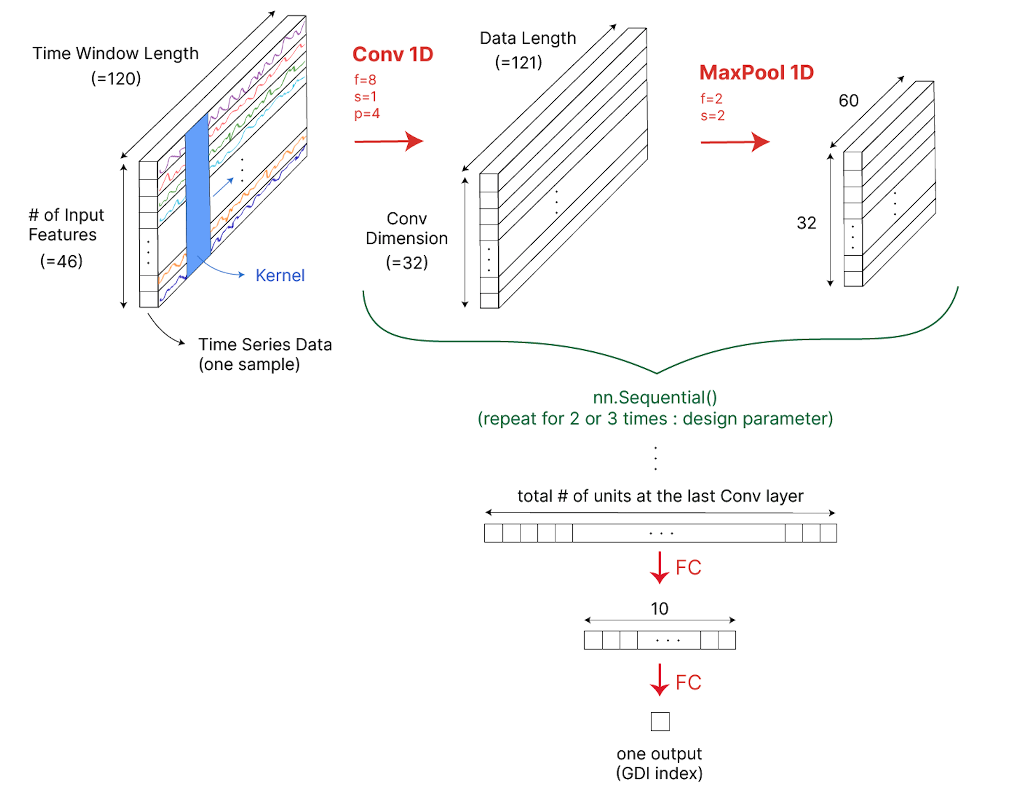



# LSTM model framework
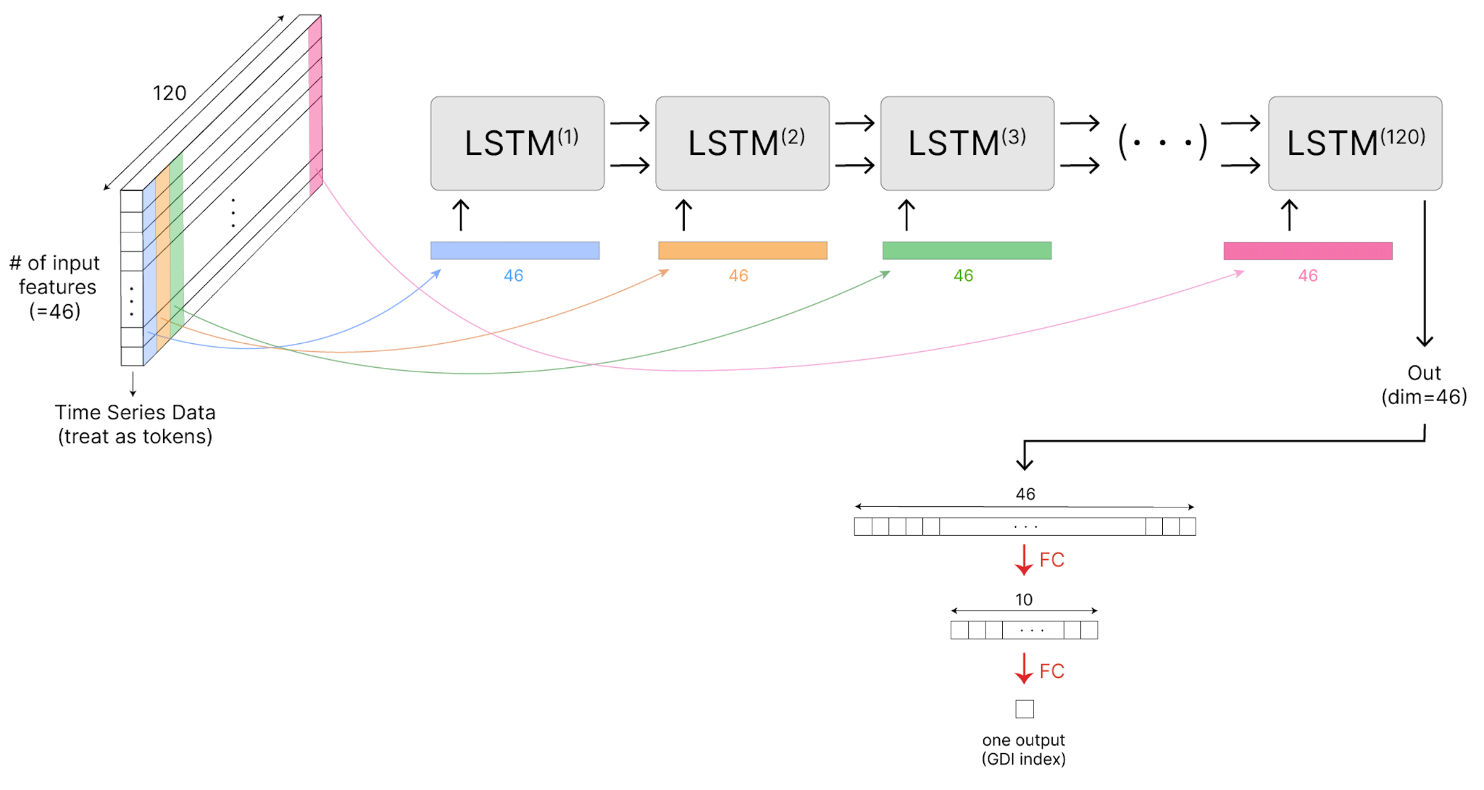


# CNN-LSTM
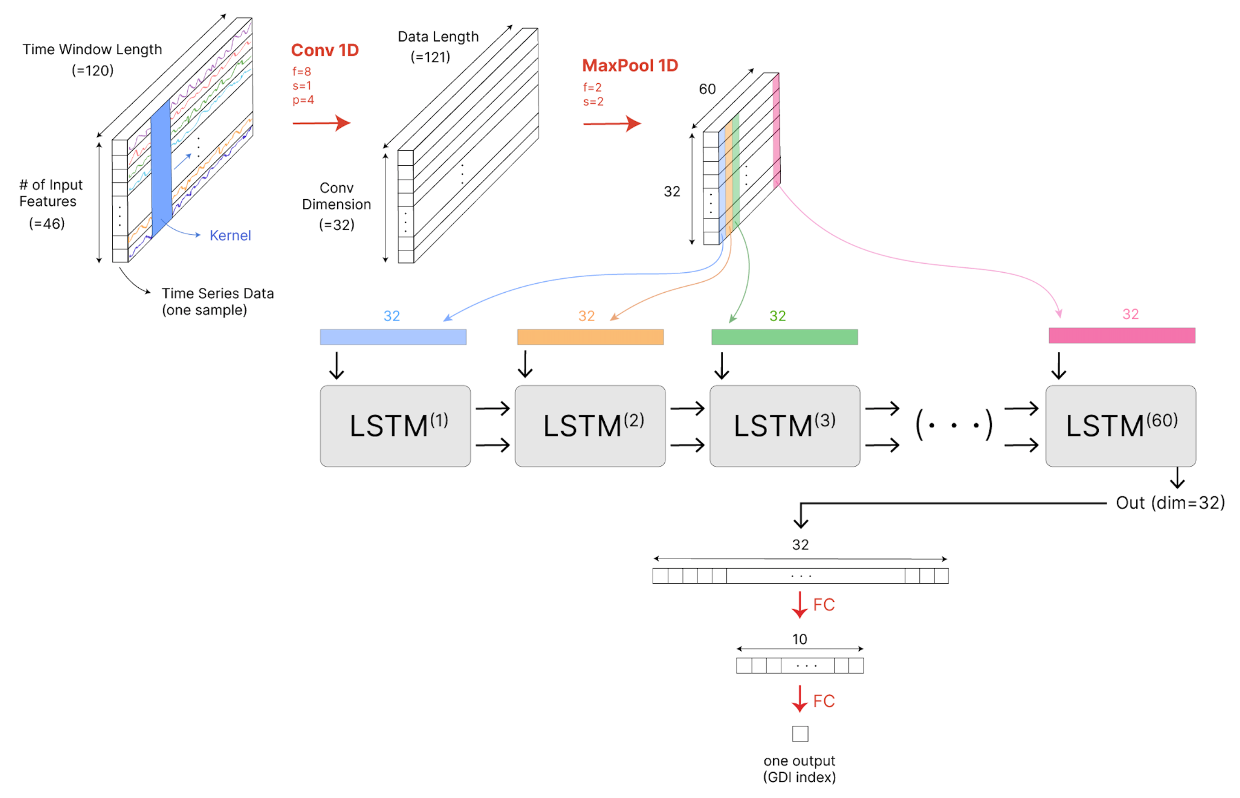

## Model and training functions

In [ ]:
class RegressionCNN(nn.Module):
  
    def __init__(self, kernel, conv_dim , input_channels, num_conv=3, 
                 data_length = 120, output_dim =1):
      
        # first call parent's initialization function
        super().__init__()

        padding = kernel // 2

        self.conv1 = nn.Sequential(nn.Conv1d(input_channels, conv_dim, 
                                            kernel, padding=padding),
                                  nn.ReLU(), nn.BatchNorm1d(conv_dim),
                                  nn.Conv1d(conv_dim, conv_dim,
                                            kernel,padding=padding),
                                  nn.ReLU(),nn.BatchNorm1d(conv_dim),
                                  nn.MaxPool1d(2),
                                  nn.Dropout()
                                  )
        
        self.conv2 = nn.Sequential(nn.Conv1d(conv_dim, conv_dim, 
                                            kernel, padding=padding),
                                  nn.ReLU(), nn.BatchNorm1d(conv_dim),
                                  nn.Conv1d(conv_dim, conv_dim,
                                            kernel,padding=padding),
                                  nn.ReLU(),nn.BatchNorm1d(conv_dim),
                                  nn.MaxPool1d(2),
                                  nn.Dropout()
                                  )

        self.conv3 = nn.Sequential(nn.Conv1d(conv_dim, conv_dim, 
                                            kernel, padding=padding),
                                  nn.ReLU(), nn.BatchNorm1d(conv_dim),
                                  nn.Conv1d(conv_dim, conv_dim,
                                            kernel,padding=padding),
                                  nn.ReLU(),nn.BatchNorm1d(conv_dim),
                                  nn.MaxPool1d(3),
                                  nn.Dropout()
                                  )
        if num_conv==3:
          fc_shape = conv_dim* (data_length//2//2//3+1-kernel%2)
        elif num_conv==2:
          fc_shape = conv_dim* (data_length//2//3+1-kernel%2)
        else:
          print('Error: num_conv should be either 2 or 3')
        self.num_conv=num_conv

        self.fc1 = nn.Sequential (nn.Linear(fc_shape,10),
                                  nn.ReLU()
                                  )
        self.final = nn.Linear(10,output_dim)
        

    def forward(self, x):
        out = self.conv1(x)
        if self.num_conv ==3:
          out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(-1,out.shape[1]*out.shape[2])
        out = self.fc1(out)
        out = self.final(out)

        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_dim=1):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, # dimension of the input repr
                          hidden_size, # dimension of the hidden units
                          batch_first=True, # input format is [batch_size, seq_len, repr_dim]
                            )

        self.fc1 = nn.Sequential ( nn.Linear(hidden_size, 10),
                                  nn.ReLU())
        self.fc2 = nn.Linear(10, output_dim)
        self.input_size = input_size
        self.output_dim =output_dim



    def forward(self, x):

      out = torch.transpose(x,2,1)

      # Set an initial hidden state
      h0 = torch.zeros(1, x.size(0), self.input_size)
      c0 = torch.zeros(1, x.size(0), self.input_size)

      if torch.cuda.is_available():
        h0=h0.cuda()
        c0=c0.cuda()
        
      # Forward propagate the RNN
      out, _ = self.lstm(out, (h0,c0))

      # Pass the output of the last time step to the classifier
      out = torch.max(out, dim=1)[0]

      out = self.fc1(out)
      out = self.fc2(out)

      if self.output_dim ==1:
        return out
      
      else:
        return out.squeeze()

In [ ]:
# dataloader for batching samples
def get_batch(x, y, batch_size):
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]

    #Shuffle
    np.random.seed(0)
    idx = np.arange(N)
    np.random.shuffle(idx)
    X=x[idx]
    Y=y[idx]

    for i in range(0, N, batch_size):
        batch_x = X[i : i + batch_size, :, :]
        batch_y = Y[i : i + batch_size, :]
        yield (batch_x, batch_y)

In [ ]:
from torch.autograd import Variable
import numpy.random as npr

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

In previous part, we have obtained multiple windows for each video. The model will predict GDI for each of the window. Hoever, in application, we want to obtain only one GDI for each video. So, we want to obtain the mean or median of the windows for each data. 
While evaluating the model, we will observe the training curve of loss and also the MAE of the each **video** .

In [ ]:
def evaluate (X,y, id, model):
  '''
  Evaluate the performance of the model
  Args:
    X: features
    y: labels
    id: examid
    model: regression model
  Returns:
    loss: MSE Loss
    mae_median: The MAE of each of the exams, by comparing the true labels and the median of predicted labels for each exam
    mae: The MAE of each windows
    pred_exam: Dictionary includes 1)Mean of predicted GDI, 
              2) Median of predicted GDI, 3) True Label, 
              4) Error of "mean predicted" and true labels, 
              5) Error of "median predicted" and true labels,
              6) Maximum of predicted GDI, 7) Minimum of predicted GDI,
              8) STD of predicted GDI, 9) Skewness of predicted GDI,
              for each of the exams
  '''

  #Obtain the prediction of model
  if torch.cuda.is_available():

    pred = torch.Tensor() #Prediction of model

    #Predict GDI with batchsize of 5000
    #batching is required due to cuda memory limitation
    for i in range (0,X.shape[0],5000):

      x = X[i:i+5000].cuda()
      t= y[i:i+5000].cuda()
      out = model(x)
      pred=torch.cat([pred,out.cpu().detach()])

  else:
    pred = model (X)

 
  mse = nn.MSELoss()
  loss = mse(pred,y)

  pred_exam = {}

  #Convert the var to numpy 
  try:
    t= y.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
  except:
    t= y.detach().numpy()
    pred = pred.detach().numpy()

  mae = abs(pred.flatten()-t.flatten()).mean() #Compute the overall MAE

  for i in set(id):
    idx = np.where(id==i)
    pred_exam[i]=[pred[idx].mean(axis=0), #Mean of predicted GDI
                  np.median(pred[idx],axis=0), #Median of predicted GDI
                  t[idx[0][0]], #Correct label
                  abs(t[idx[0][0]] - pred[idx].mean(axis=0)), #error of mean predicted GDI
                  abs(t[idx[0][0]] - np.median(pred[idx],axis=0)), #error of median predicted GDI
                  pred[idx].max(axis=0), #Max of predicted GDI
                  pred[idx].min(axis=0), #Min of predicted GDI
                  pred[idx].std(axis=0), #Standard Deviation of predicted GDI
                  scipy.stats.skew(pred[idx],axis=0), #Skewness
                  ]
  error_mean = [i[3] for i in pred_exam.values()]
  error_median = [i[4] for i in pred_exam.values()]

  mae_mean = np.mean(error_mean)
  mae_median = np.mean(error_median)

  return loss, mae_median, mae, pred_exam

#Code for testing the functions
x = X_train[:6000]
y= y_train[:6000]
id=id_train[:6000]
model = RegressionCNN(3,32,X_train.shape[1])
model = model.cuda()
_,_,_,check=evaluate(x,y,id,model)


In [ ]:
def train(X_train, y_train, id_train, 
          X_val, y_val, id_val, 
          model, 
          learning_rate, batch_size, epochs, weight_decay = 1e-5, 
          seed=0, plot=True):

    # random seed
    npr.seed(seed)
    torch.manual_seed(seed)

    # LOAD THE MODEL

    if torch.cuda.is_available():
      model.cuda()

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                          momentum=0.9, weight_decay=weight_decay)

    print("Beginning training ...")
    start = time.time()

    iters = []
    train_losses = []
    val_losses = []
    train_maes1 = []
    val_maes1 = []
    train_maes2 = []
    val_maes2 = []
    cnt = 0
    lr_reduce =1

    n = 0
    for epoch in range(epochs):
        model.train()  

        # loop over training batch to train the model, for each epoch. 
        for i, (xs, ys) in enumerate(get_batch(X_train, y_train, batch_size)):
            
            if torch.cuda.is_available():
              xs = xs.cuda()
              ys = ys.cuda()

            xs, ys = Variable(xs), Variable(ys)
            
            optimizer.zero_grad()

            # calculating training loss
            outputs = model(xs)
            loss = criterion(outputs, ys)

            # updating the weights based on training loss
            loss.backward()
            optimizer.step()


        train_loss, train_mae2, train_mae1,_ = evaluate(X_train,y_train,id_train,
                                                        model)
        val_loss, val_mae2, val_mae1,_ = evaluate(X_val,y_val,id_val,model)

        train_losses.append(train_loss)
        train_maes1.append(train_mae1)
        train_maes2.append(train_mae2)
        val_losses.append(val_loss)
        val_maes1.append(val_mae1)
        val_maes2.append(val_mae2)

        if val_mae1 <= min(val_maes1):
          best_model = model
          cnt =0
        else:
          cnt+=1

        print('epoch', epoch, 'train_loss', train_loss,
              'val_loss', val_loss, 'train_MAE',train_mae1,'val_MAE', val_mae1)

        #Reduce lr if no improvement for 5 epochs
        if cnt>=5:
          if lr_reduce <=3:
            optimizer = optim.SGD(model.parameters(), 
                                  lr=learning_rate*(0.1**lr_reduce), 
                                  momentum=0.9, weight_decay=weight_decay)
            print ('Reduce learning rate to ', learning_rate*(0.1**lr_reduce))
            lr_reduce +=1
            cnt=0
            model = best_model #Load the best model before continue
            model.train()
          else:
            print('Training ends at epoch ', epoch)
            break

          

    # plotting
    if plot:
        plt.title("Training Curve: Loss")
        plt.plot(np.arange(epoch+1), train_losses, label="Train")
        plt.plot(np.arange(epoch+1), val_losses, label="Validation")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
        

        plt.title("MAE for each window")
        plt.plot(np.arange(epoch+1), train_maes1, label="Train")
        plt.plot(np.arange(epoch+1), val_maes1, label="Validation")
        plt.xlabel("Iterations")
        plt.ylabel("MAE")
        plt.legend(loc='best')
        plt.show()

        plt.title("MAE for each exam (Median GDI)")
        plt.plot(np.arange(epoch+1), train_maes2, label="Train")
        plt.plot(np.arange(epoch+1), val_maes2, label="Validation")
        plt.xlabel("Iterations")
        plt.ylabel("MAE")
        plt.legend(loc='best')
        plt.show()

    print('Elapsed Time: ', time.time()-start)
    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print('---------')
    print("Best epoch: ", np.array(val_maes2).argmin())
    print('Lowest val_MAE: ', np.array(val_maes2).min())
    
    return best_model

Beginning training ...
epoch 0 train_loss tensor(138.3387) val_loss tensor(128.1148) train_MAE 9.384675 val_MAE 9.034558
epoch 1 train_loss tensor(149.8132) val_loss tensor(140.4914) train_MAE 9.808316 val_MAE 9.500723
epoch 2 train_loss tensor(116.8688) val_loss tensor(109.1357) train_MAE 8.606974 val_MAE 8.346866
epoch 3 train_loss tensor(106.4719) val_loss tensor(99.5821) train_MAE 8.23439 val_MAE 7.976053
epoch 4 train_loss tensor(110.0070) val_loss tensor(104.0509) train_MAE 8.364792 val_MAE 8.173655
epoch 5 train_loss tensor(90.6664) val_loss tensor(86.5820) train_MAE 7.592208 val_MAE 7.457253
epoch 6 train_loss tensor(86.6430) val_loss tensor(84.4430) train_MAE 7.438581 val_MAE 7.3353586
epoch 7 train_loss tensor(83.7171) val_loss tensor(82.1241) train_MAE 7.3017426 val_MAE 7.261927
epoch 8 train_loss tensor(82.0594) val_loss tensor(80.5166) train_MAE 7.2331634 val_MAE 7.204527
epoch 9 train_loss tensor(79.9301) val_loss tensor(80.6808) train_MAE 7.1427693 val_MAE 7.2366314
epoc

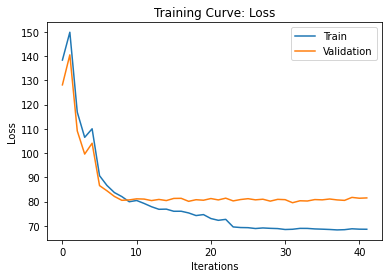

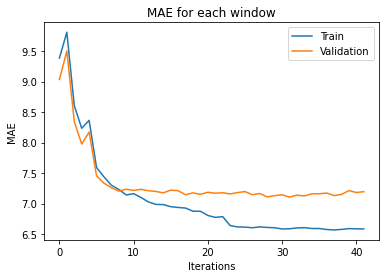

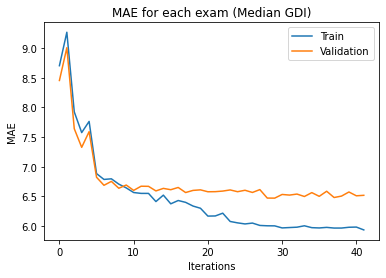

Elapsed Time:  629.4503426551819
Final Training Loss: 68.58224487304688
Final Validation Loss: 81.5032958984375
---------
Best epoch:  29
Lowest val_MAE:  6.4695373


In [ ]:
#Prediction using the CNN model

input_channels = X_train.shape[1]
data_length = X_train.shape[2]

#Define model 
model = RegressionCNN(kernel =8,
                      conv_dim=32,
                      input_channels=input_channels,
                      num_conv=3,
                      data_length = data_length)
#Train model
model =train(X_train,y_train,id_train,
             X_val,y_val,id_val,
             model=model,
             learning_rate =1e-4,
             batch_size =32,
             epochs=100
             )

#Save the model 
path = 'CNN_3layers_32dim'
torch.save(model.state_dict(),path)

Seems overfitting appears in previous trials. Try to remove some time series features that are likely to be irrelevant to prediction, to avoid the model to over-reacted to those noise.

In [ ]:
selected_features  = [-1,-2,-3,-4,-5,-6] #List of columns


for i in  ['MidHip','RHip','RKnee','RAnkle',
           'LHip','LKnee','LAnkle',  'LBigToe',
           'LSmallToe','LHeel','RBigToe','RSmallToe',
           'RHeel']:

    selected_features.append(new_map[i+'_x'])
    selected_features.append(new_map[i+'_y']) 

# Create new X_train and X_val which only include selected features
X_train_s =X_train[:,selected_features]
X_val_s = X_val[:,selected_features]
X_test_s = X_test[:,selected_features]
print(X_train_s.shape)

torch.Size([26230, 32, 120])


Beginning training ...
epoch 0 train_loss tensor(144.9563) val_loss tensor(136.6336) train_MAE 9.634198 val_MAE 9.379025
epoch 1 train_loss tensor(150.6368) val_loss tensor(143.4793) train_MAE 9.853817 val_MAE 9.678781
epoch 2 train_loss tensor(126.1619) val_loss tensor(120.9722) train_MAE 8.9639225 val_MAE 8.818022
epoch 3 train_loss tensor(110.0392) val_loss tensor(106.2000) train_MAE 8.366082 val_MAE 8.265342
epoch 4 train_loss tensor(112.2888) val_loss tensor(109.4492) train_MAE 8.433236 val_MAE 8.362844
epoch 5 train_loss tensor(90.6594) val_loss tensor(89.2271) train_MAE 7.601023 val_MAE 7.4982753
epoch 6 train_loss tensor(86.1245) val_loss tensor(86.4318) train_MAE 7.3917837 val_MAE 7.3890953
epoch 7 train_loss tensor(82.9192) val_loss tensor(82.8803) train_MAE 7.25869 val_MAE 7.241638
epoch 8 train_loss tensor(81.9174) val_loss tensor(82.3913) train_MAE 7.217734 val_MAE 7.189491
epoch 9 train_loss tensor(80.7633) val_loss tensor(83.3628) train_MAE 7.179308 val_MAE 7.2278633
epo

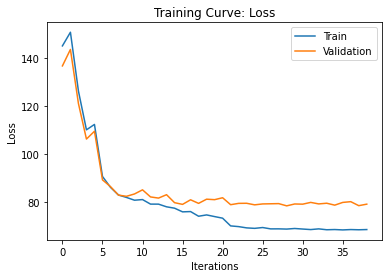

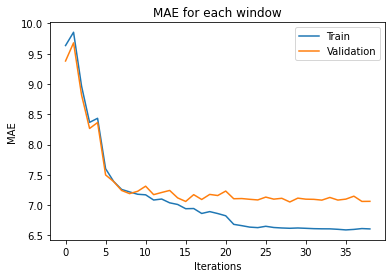

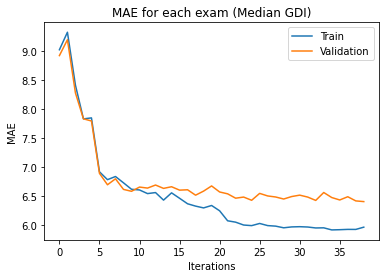

Elapsed Time:  351.6529767513275
Final Training Loss: 68.55679321289062
Final Validation Loss: 79.12225341796875
---------
Best epoch:  38
Lowest val_MAE:  6.407921


In [ ]:
input_channels = X_train_s.shape[1]
data_length = X_train_s.shape[2]

#Define model 
model = RegressionCNN(kernel =8,
                      conv_dim=32,
                      input_channels=input_channels,
                      num_conv=3,
                      data_length = data_length)
#Train model
model =train(X_train_s,y_train,id_train,
             X_val_s,y_val,id_val,
             model=model,
             learning_rate =1e-4,
             batch_size =32,
             epochs=100
             )

#Save the model 
path = '32features_CNN_3layers_32dim'
torch.save(model.state_dict(),path)

Now, try to use LSTM instead

Beginning training ...
epoch 0 train_loss tensor(95.4555) val_loss tensor(88.2265) train_MAE 7.8318515 val_MAE 7.5614395
epoch 1 train_loss tensor(80.3420) val_loss tensor(76.1165) train_MAE 7.1612253 val_MAE 6.992894
epoch 2 train_loss tensor(77.1384) val_loss tensor(74.1563) train_MAE 7.0145035 val_MAE 6.89248
epoch 3 train_loss tensor(74.6663) val_loss tensor(73.0310) train_MAE 6.895072 val_MAE 6.8282866
epoch 4 train_loss tensor(72.1942) val_loss tensor(72.6773) train_MAE 6.7695975 val_MAE 6.7937226
epoch 5 train_loss tensor(70.7376) val_loss tensor(72.5234) train_MAE 6.7017465 val_MAE 6.7895155
epoch 6 train_loss tensor(69.3393) val_loss tensor(72.5362) train_MAE 6.6284013 val_MAE 6.776107
epoch 7 train_loss tensor(68.2319) val_loss tensor(72.7032) train_MAE 6.5780725 val_MAE 6.7768116
epoch 8 train_loss tensor(67.0244) val_loss tensor(72.9099) train_MAE 6.5315337 val_MAE 6.7910595
epoch 9 train_loss tensor(66.0813) val_loss tensor(73.1675) train_MAE 6.488652 val_MAE 6.811466
epoc

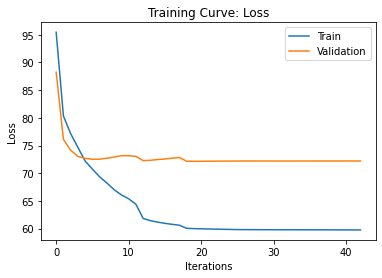

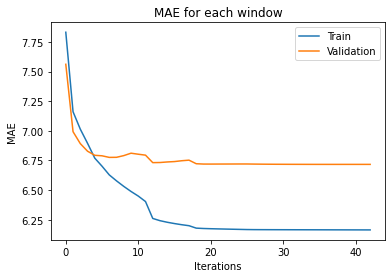

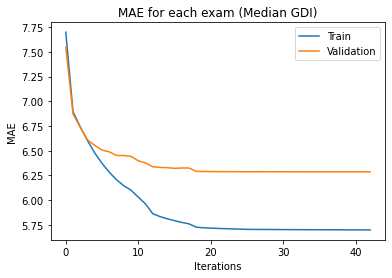

Elapsed Time:  342.857314825058
Final Training Loss: 59.761817932128906
Final Validation Loss: 72.2103271484375
---------
Best epoch:  42
Lowest val_MAE:  6.286156


In [ ]:
input_channels = X_train.shape[1]
data_length = X_train.shape[2]

#Define model 
model = LSTM(input_channels,
             input_channels)

#Train model
model =train(X_train,y_train,id_train,
             X_val,y_val,id_val,
             model=model,
             learning_rate =1e-4,
             batch_size =32,
             epochs=200
             )

#Save the model 
path = 'LSTM_bs32'
torch.save(model.state_dict(),path)

Now try CNN-LSTM also

In [ ]:
class CNN_LSTM(nn.Module):
  
    def __init__(self, input_channels, kernel=8, conv_dim=32 , num_conv=3, 
                 data_length = 120, output_dim=1,num_fc=2):
        # first call parent's initialization function
        super().__init__()

        padding = kernel // 2

        self.conv1 = nn.Sequential(nn.Conv1d(input_channels, conv_dim, 
                                            kernel, padding=padding),
                                  nn.ReLU(), nn.BatchNorm1d(conv_dim),
                                  nn.Conv1d(conv_dim, conv_dim,
                                            kernel,padding=padding),
                                  nn.ReLU(),nn.BatchNorm1d(conv_dim),
                                  nn.MaxPool1d(2),
                                  nn.Dropout()
                                  )
        
        self.conv2 = nn.Sequential(nn.Conv1d(conv_dim, conv_dim, 
                                            kernel, padding=padding),
                                  nn.ReLU(), nn.BatchNorm1d(conv_dim),
                                  nn.Conv1d(conv_dim, conv_dim,
                                            kernel,padding=padding),
                                  nn.ReLU(),nn.BatchNorm1d(conv_dim),
                                  nn.MaxPool1d(2),
                                  nn.Dropout()
                                  )

        self.conv3 = nn.Sequential(nn.Conv1d(conv_dim, conv_dim, 
                                            kernel, padding=padding),
                                  nn.ReLU(), nn.BatchNorm1d(conv_dim),
                                  nn.Conv1d(conv_dim, conv_dim,
                                            kernel,padding=padding),
                                  nn.ReLU(),nn.BatchNorm1d(conv_dim),
                                  nn.MaxPool1d(3),
                                  nn.Dropout()
                                  )

        if num_conv==3:
          fc_shape = data_length//2//2//3+1-kernel%2
        elif num_conv==2:
          fc_shape = data_length//2//3+1-kernel%2
        elif num_conv==1:
          fc_shape = data_length//2+1-kernel%2
        else:
          print('Error: num_conv should be either 1, 2 or 3')
                

        self.lstm = nn.LSTM(conv_dim,
                          conv_dim,
                          batch_first=True,
                            )
                            
        self.fc1 = nn.Sequential (nn.Linear(conv_dim*2,10),
                                  nn.ReLU()
                                  )
        self.fc2 = nn.Linear(10,output_dim)
        self.fc3 = nn.Linear(output_dim,output_dim)

        self.num_conv=num_conv  
        self.output_dim =output_dim
        self.num_fc=num_fc
        

    def forward(self, x):
        out = self.conv1(x)
        if self.num_conv >=3:
          out = self.conv2(out)
        if self.num_conv>=2:
          out = self.conv3(out)
        out = out.view(-1,out.shape[1], out.shape[2])
        out = torch.transpose(out,2,1)

        # Set an initial hidden state
        h0 = torch.zeros(1, out.shape[0],out.shape[2])
        c0 = torch.zeros(1, out.shape[0],out.shape[2])

        if torch.cuda.is_available():
          h0=h0.cuda()
          c0=c0.cuda()

        # Forward propagate the RNN
        out, _ = self.lstm(out, (h0,c0))

        out = torch.cat([torch.max(out, dim=1)[0], 
                          torch.mean(out, dim=1)], dim=1)
        

        out = self.fc1(out)
        
        if self.num_fc >=3:
          out = F.relu(self.fc2(out))
          out = self.fc3(out)
        else:
          out= self.fc2(out)
  
        if self.output_dim ==1:
          return out
        else: 
          return out.squeeze()

Beginning training ...
epoch 0 train_loss tensor(84.7205) val_loss tensor(77.9486) train_MAE 7.3463216 val_MAE 7.0723405
epoch 1 train_loss tensor(80.1152) val_loss tensor(75.6485) train_MAE 7.134261 val_MAE 6.9394197
epoch 2 train_loss tensor(78.3064) val_loss tensor(74.6766) train_MAE 7.058893 val_MAE 6.8862996
epoch 3 train_loss tensor(77.0453) val_loss tensor(75.0113) train_MAE 6.99974 val_MAE 6.883896
epoch 4 train_loss tensor(76.3464) val_loss tensor(76.2747) train_MAE 6.9633803 val_MAE 6.952524
epoch 5 train_loss tensor(74.0870) val_loss tensor(74.9316) train_MAE 6.8575964 val_MAE 6.887284
epoch 6 train_loss tensor(73.5157) val_loss tensor(75.5529) train_MAE 6.835801 val_MAE 6.9381266
epoch 7 train_loss tensor(72.0540) val_loss tensor(75.0734) train_MAE 6.773193 val_MAE 6.898785
epoch 8 train_loss tensor(72.0687) val_loss tensor(75.4446) train_MAE 6.751633 val_MAE 6.918096
Reduce learning rate to  1e-05
epoch 9 train_loss tensor(68.5788) val_loss tensor(72.1547) train_MAE 6.6055

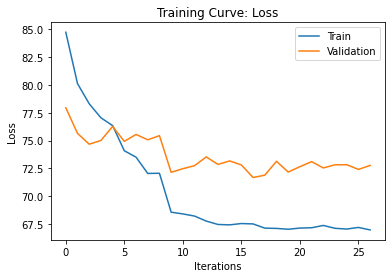

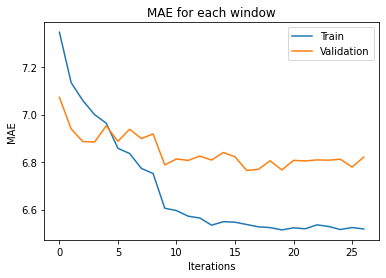

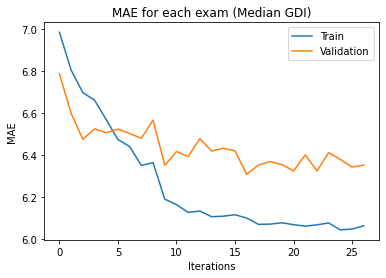

Elapsed Time:  388.8963258266449
Final Training Loss: 66.98728942871094
Final Validation Loss: 72.77474975585938
---------
Best epoch:  16
Lowest val_MAE:  6.3090906


In [ ]:
input_channels = X_train.shape[1]
data_length = X_train.shape[2]

#Define model 
model = CNN_LSTM(conv_dim=32,
                input_channels=input_channels,
                num_conv=1,
                data_length = data_length,
                 num_fc=2)
#Train model
model =train(X_train,y_train,id_train,
             X_val,y_val,id_val,
             model=model,
             learning_rate =1e-4,
             batch_size =32,
             epochs=1000
             )

#Save the model 
path = 'CNNLSTM_1layers_32dim'
torch.save(model.state_dict(),path)

Beginning training ...
epoch 0 train_loss tensor(86.4617) val_loss tensor(82.7843) train_MAE 7.4273214 val_MAE 7.270183
epoch 1 train_loss tensor(82.7149) val_loss tensor(79.1480) train_MAE 7.264617 val_MAE 7.0984125
epoch 2 train_loss tensor(81.9208) val_loss tensor(79.4597) train_MAE 7.227389 val_MAE 7.0952587
epoch 3 train_loss tensor(79.7816) val_loss tensor(77.9487) train_MAE 7.1415687 val_MAE 7.003527
epoch 4 train_loss tensor(80.6027) val_loss tensor(79.3319) train_MAE 7.180337 val_MAE 7.0833716
epoch 5 train_loss tensor(78.4066) val_loss tensor(77.7559) train_MAE 7.0805244 val_MAE 6.995363
epoch 6 train_loss tensor(78.6654) val_loss tensor(78.0126) train_MAE 7.088341 val_MAE 7.028914
epoch 7 train_loss tensor(77.8582) val_loss tensor(76.8608) train_MAE 7.052756 val_MAE 6.9729204
epoch 8 train_loss tensor(77.6120) val_loss tensor(77.2060) train_MAE 7.0477614 val_MAE 6.989959
epoch 9 train_loss tensor(76.7524) val_loss tensor(76.6122) train_MAE 7.003853 val_MAE 6.9531236
epoch 10

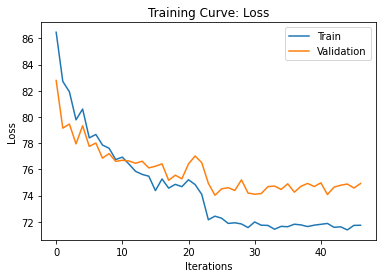

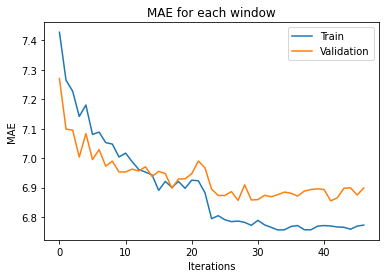

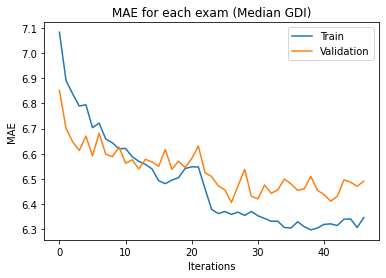

Elapsed Time:  504.7617483139038
Final Training Loss: 71.74004364013672
Final Validation Loss: 74.92491912841797
---------
Best epoch:  26
Lowest val_MAE:  6.406588


In [ ]:
input_channels = X_train.shape[1]
data_length = X_train.shape[2]

#Define model 
model = CNN_LSTM(conv_dim=8,
                input_channels=input_channels,
                num_conv=1,
                data_length = data_length,
                 num_fc=2)
#Train model
model =train(X_train,y_train,id_train,
             X_val,y_val,id_val,
             model=model,
             learning_rate =1e-4,
             batch_size =32,
             epochs=1000
             )

#Save the model 
path = 'CNNLSTM_1layers_8dim'
torch.save(model.state_dict(),path)

Beginning training ...
epoch 0 train_loss tensor(89.6153) val_loss tensor(80.6443) train_MAE 7.562362 val_MAE 7.2043276
epoch 1 train_loss tensor(81.1340) val_loss tensor(75.3696) train_MAE 7.2034044 val_MAE 6.955797
epoch 2 train_loss tensor(79.1650) val_loss tensor(74.5293) train_MAE 7.1146283 val_MAE 6.923699
epoch 3 train_loss tensor(76.8759) val_loss tensor(74.4576) train_MAE 7.016487 val_MAE 6.9114285
epoch 4 train_loss tensor(76.2666) val_loss tensor(74.6686) train_MAE 6.9949665 val_MAE 6.9147606
epoch 5 train_loss tensor(74.6945) val_loss tensor(73.6317) train_MAE 6.912495 val_MAE 6.84722
epoch 6 train_loss tensor(74.7030) val_loss tensor(72.2978) train_MAE 6.910993 val_MAE 6.8316917
epoch 7 train_loss tensor(73.6299) val_loss tensor(73.1921) train_MAE 6.876181 val_MAE 6.840624
epoch 8 train_loss tensor(72.2496) val_loss tensor(72.4527) train_MAE 6.8016443 val_MAE 6.7809024
epoch 9 train_loss tensor(72.5426) val_loss tensor(73.2820) train_MAE 6.820055 val_MAE 6.8621783
epoch 10

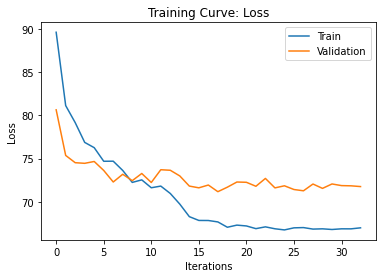

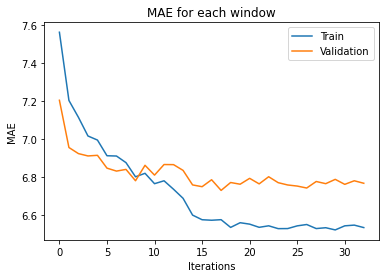

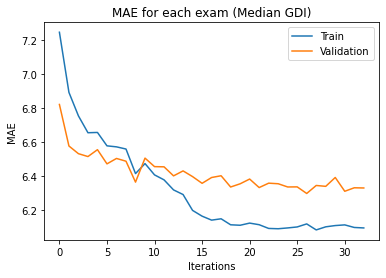

Elapsed Time:  509.48672556877136
Final Training Loss: 66.9964599609375
Final Validation Loss: 71.76823425292969
---------
Best epoch:  26
Lowest val_MAE:  6.29895


In [ ]:
input_channels = X_train.shape[1]
data_length = X_train.shape[2]

#Define model 
model = CNN_LSTM(conv_dim=32,
                input_channels=input_channels,
                num_conv=1,
                data_length = data_length,
                 num_fc=2)
#Train model
model =train(X_train,y_train,id_train,
             X_val,y_val,id_val,
             model=model,
             learning_rate =1e-4,
             batch_size =128,
             epochs=1000
             )

#Save the model 
path = 'CNNLSTM_1layers_32dim_bs128'
torch.save(model.state_dict(),path)

Seems the models have similar performance. Now try to apply the model on test set

In [ ]:
path = 'CNNLSTM_1layers_32dim_bs128'

input_channels = X_train.shape[1]
data_length = X_train.shape[2]

model = CNN_LSTM(conv_dim=32,
                input_channels=input_channels,
                num_conv=1,
                data_length = data_length).cuda()
state = torch.load(path)
model.load_state_dict(state)

evaluate(X_test,y_test,id_test,model)[1]

6.7604513

Recall that GDI 100 or above means healthy gait, and 10 point decrease means one standard deviation from healthy standard.

The validation MAE of best model is around 6.2 and test MAE of 6.8, and this seems to be an acceptable performance

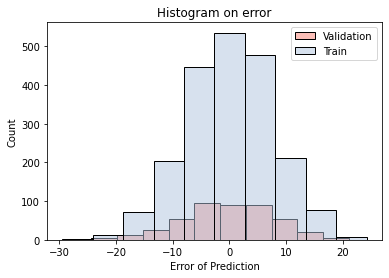

Prediction vs Label (Traning Set)


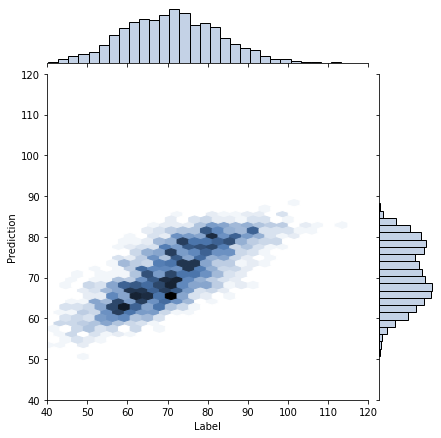

Prediction vs Label (Validation Set)


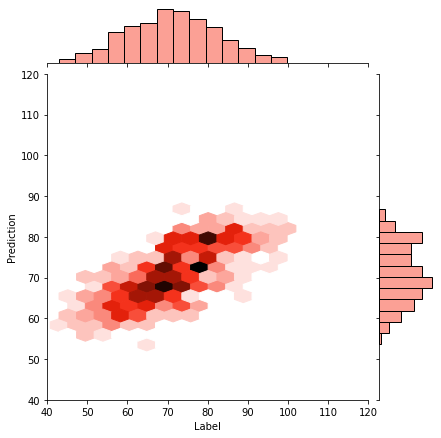

In [ ]:
# Obtain predicted values and true values of gait examinations for further analysis
_,_,_,val_result = evaluate(X_val,y_val,id_val,model)
_,_,_,train_result = evaluate(X_train,y_train,id_train,model)

val_pred = np.array([i[0] for i in val_result.values()])
val_label = np.array([i[2] for i in val_result.values()])

train_pred = np.array([i[0] for i in train_result.values()])
train_label = np.array([i[2] for i in train_result.values()])

val_diff = (val_pred - val_label)
train_diff = (train_pred - train_label)

#Plot histogram to see the distribution of errors
sns.histplot(val_diff.flatten(),bins=10, alpha=0.5, 
             color='salmon', label = 'Validation')
sns.histplot(train_diff.flatten(),bins=10, alpha=0.5, 
             color='lightsteelblue', label = 'Train')
plt.legend()
plt.xlabel('Error of Prediction')
plt.title('Histogram on error')
plt.show()

#Plot scatter plots to compare predicted values and true values
print('Prediction vs Label (Traning Set)')
sns.jointplot(x=train_label.flatten(), y=train_pred.flatten(),
              kind='hex', color = 'lightsteelblue')
              
plt.xlabel('Label')
plt.ylabel('Prediction')
plt.xlim(40,120)
plt.ylim(40,120)
plt.show()

print('Prediction vs Label (Validation Set)')
sns.jointplot(x=val_label.flatten(), y=val_pred.flatten(),
              kind='hex',color = 'salmon')
              
plt.xlabel('Label')
plt.ylabel('Prediction')
plt.xlim(40,120)
plt.ylim(40,120)
plt.show()

#New Dataset

Besides testing on the dataset, we want to verify the model using new dataset. 

We found videos on youtube, which are case studies of observational gait analysis. It means we can identify the abnormal gait visually. 

Then, we found some videos with person walking (side view) without obvious posture problem. We assumed those are "normal gait". 

Although we do not have groundth truth label of GDI for new dataset, we could try to compare the GDI for the "normal set" and "Abnormal set". The normal set is expected to have higher GDI.


Before importing dataset, we have obtained keypoints position with the use of OpenPose Software. The details of steps of obtaining keypoints positions can be found here: https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/index.html

In [ ]:
!unzip -q openpose_gait.zip -d 'openpose_gait'
!unzip -q openpose_norm.zip -d 'openpose_normal2'

vids_normal = os.listdir('openpose_normal2/')
vids_abnormal = os.listdir('openpose_gait/')

In [ ]:
#Create Tensor for abnormal set
X_abnormal=torch.Tensor()
id_abnormal = []
for vid_name in vids_abnormal:
  directory='/content/openpose_gait/'+vid_name+'/'
  features = get_features(vid_name,directory,crop=False,end=120)  
  X_abnormal=torch.cat((X_abnormal, features),0)
  id_abnormal.extend([vid_name]*features.shape[0])
print('Shape of abnormal gait features: {}'.format(X_abnormal.shape))


# Create Tensor for normal set
X_normal = torch.Tensor()
id_normal = []
for vid_name in vids_normal:
  directory='/content/openpose_normal2/'+vid_name+'/'
  try:
    features = get_features(vid_name,directory,crop=False,end=120)  
    X_normal=torch.cat((X_normal, features),0)
    id_normal.extend([vid_name]*features.shape[0])
  except:
    print('%s faced error'%vid_name)
print('Shape of Normal gait features: {}'.format(X_normal.shape))


Shape of abnormal gait features: torch.Size([30, 46, 120])
vid4 faced error
vid10 faced error
Shape of Normal gait features: torch.Size([27, 46, 120])


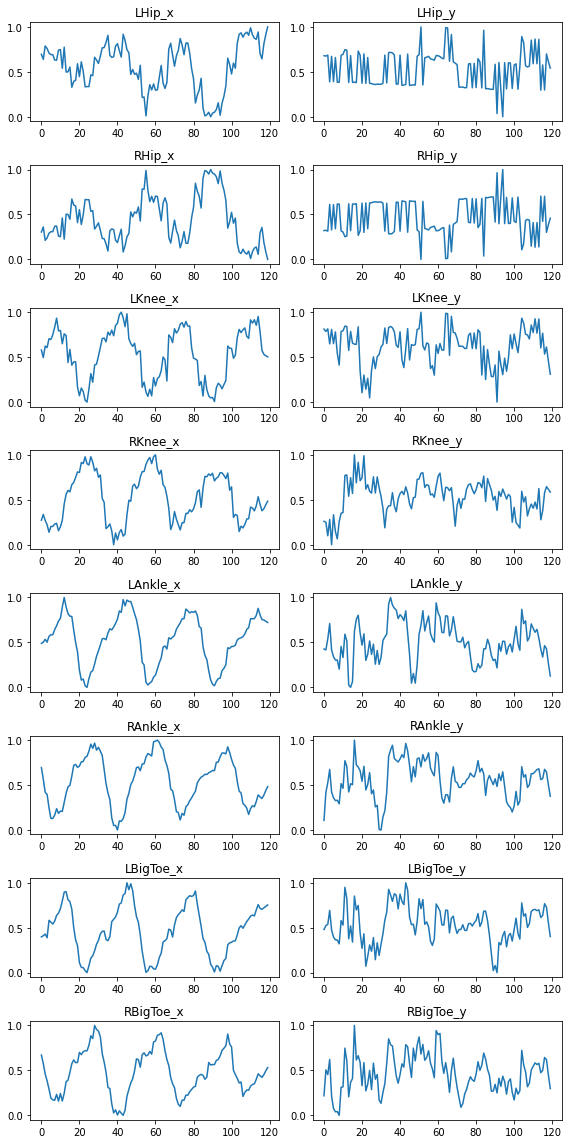

In [ ]:
#Show some of the time series for normal set
show_plots(X_normal[0],map=new_map)

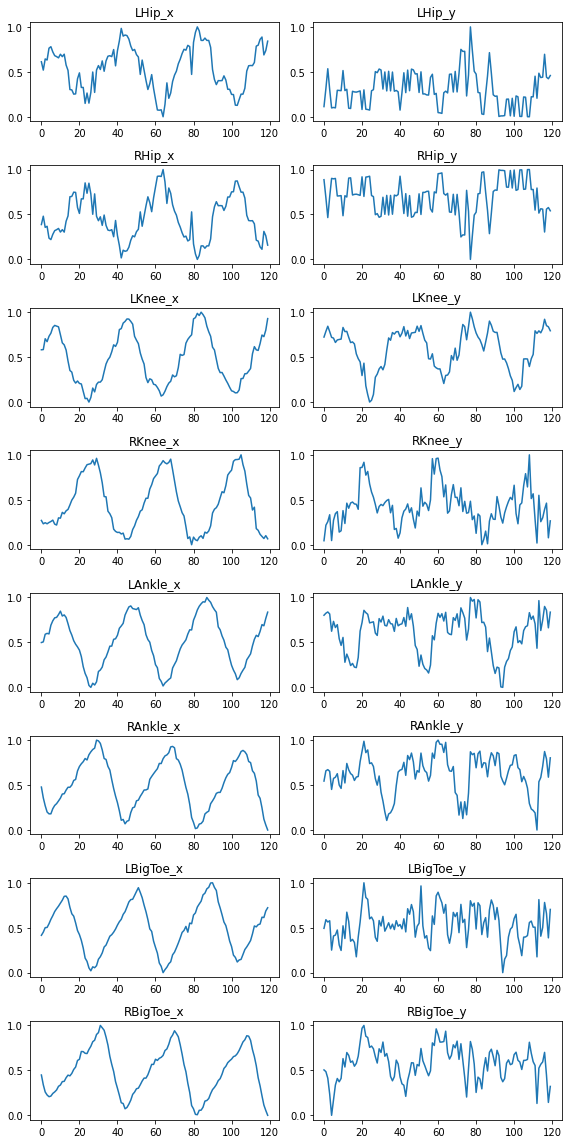

In [ ]:
#Show some of the time series for abnormal set
show_plots(X_abnormal[0],map=new_map)

In [ ]:
pred_normal = model(X_normal.cuda())
pred_normal=pred_normal.cpu().detach()
pred_GDI={}

for i in set(id_normal):
  idx = [idx for idx in range(len(id_normal)) if id_normal[idx] ==i]
  pred_GDI[i] = pred_normal[idx].mean().float()

pred_GDI

{'vid': tensor(73.3304),
 'vid1': tensor(76.1743),
 'vid11': tensor(70.9656),
 'vid12': tensor(74.9414),
 'vid13': tensor(74.9535),
 'vid14': tensor(71.4481),
 'vid15': tensor(72.8910),
 'vid2': tensor(73.8924),
 'vid5': tensor(75.6200),
 'vid6': tensor(69.8989),
 'vid7': tensor(73.5008),
 'vid8': tensor(77.5112),
 'vid9': tensor(80.6577)}

It is found that the gait videos that are visually normal got a predicted GDI of 70-80, which is lower than expected. According to the definition of GDI, the normal gait should have a score >100. 
We suspect its due to the imbalance in training data. The training data set mainly included gait examination videos for patients but not people with normal walking posture. The model tends to predict labels that is closer to the mean GDI in the training set. Therefore, the model predicts the GDI of our new dataset to be around 75 instead of 100.

In [ ]:
pred_abnormal = model(X_abnormal.cuda())
pred_abnormal=pred_abnormal.cpu().detach()
pred_GDI_abnormal={}

for i in set(id_abnormal):
  idx = [idx for idx in range(len(id_abnormal)) if id_abnormal[idx] ==i]
  pred_GDI_abnormal[i] = pred_abnormal[idx].mean().float()

pred_GDI_abnormal

{'gait1': tensor(74.3909),
 'gait2': tensor(83.1777),
 'gait3': tensor(78.6811),
 'gait4': tensor(75.0305),
 'gait5': tensor(78.7792),
 'gait6': tensor(63.6115)}

Some of the videos got a predicted GDI thats higher than the normal gait set. After reviewing the videos, we belive the reason is the gait abnormalties in the videos are not obvious in 2D videos. In the training set, the ground truth GDI was obtained from 3D sensors reading in conventional clinical set up. Thus 2D videos may provide insufficient information. 

# Conclusions

The gait deviation index may not be predicted accuractely. Thus using 2D videos to track progress of physiotherapy recovery may be difficult. However, there is still correlation relationship between the predicted values and true values of GDI. It showed the ability of deep learning to learn the walking sequence by using pose estimation and time series. This shows the potential of using deep learning as tools for physiotherapy diagnosis and health monitoring. 

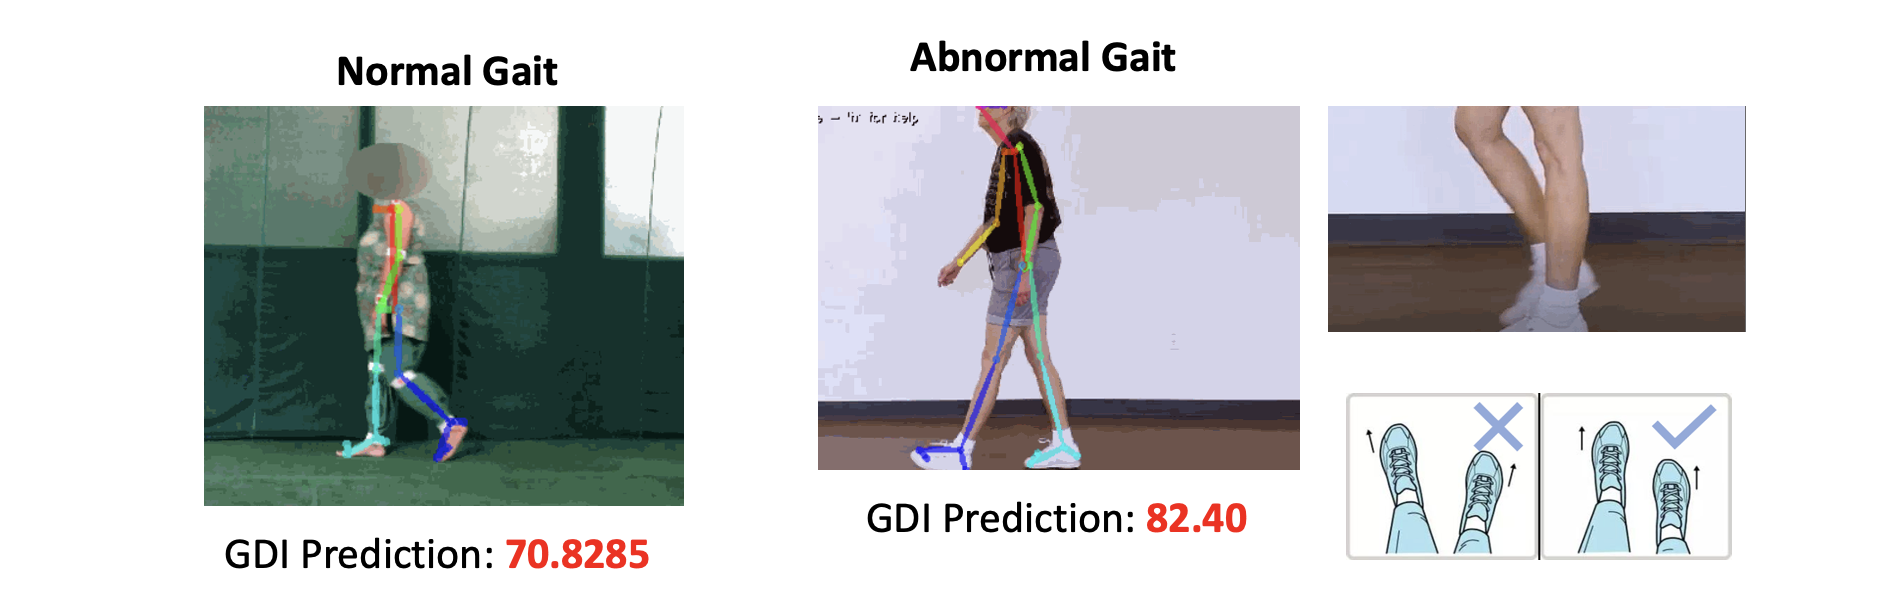